# Cancer diagnosis
### By Shashank Gurnalkar

__Problem statement:__
- Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

__Description__
- https://www.kaggle.com/c/msk-redefining-cancer-treatment/

### Loading Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [ ]:
data = pd.read_csv('training/training_variants.txt')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [ ]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [ ]:
# loading stop words from nltk library
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [ ]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 62.32787553483111 seconds


In [ ]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [ ]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
result[result['ID']==1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

In [ ]:
result.to_csv("result.csv", index=False)

In [ ]:
#extracting features to a dataframe
import os
if os.path.isfile('result.csv'):
    df = pd.read_csv("result.csv",encoding='latin-1')
    
    print("NLP Features")

NLP Features


<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [ ]:
y = df['Class'].values
df.Gene      = df.Gene.str.replace('\s+', '_')
df.Variation = df.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_, X_test, y_, y_test = train_test_split(df, y, stratify=y, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, stratify=y_, test_size=0.2)

<p> We split the data into train and test data sets, preserving the ratio of class distribution in the original data set  </p>

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

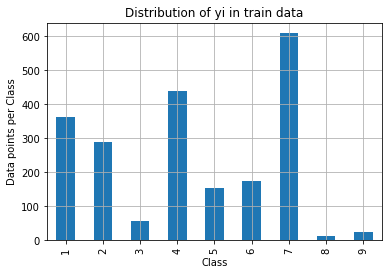

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


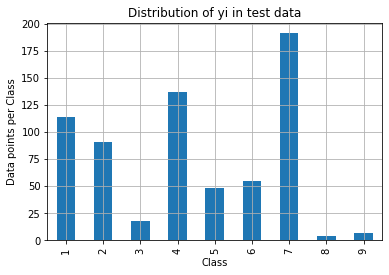

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


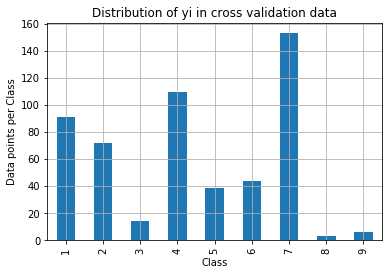

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = X_train['Class'].value_counts().sort_index()
test_class_distribution = X_test['Class'].value_counts().sort_index()
cv_class_distribution = X_cv['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

print('-'*80)

my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/X_cv.shape[0]*100), 3), '%)')


<h2>3.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Test Data using Random Model 2.4811371530671025
-------------------- Confusion matrix --------------------


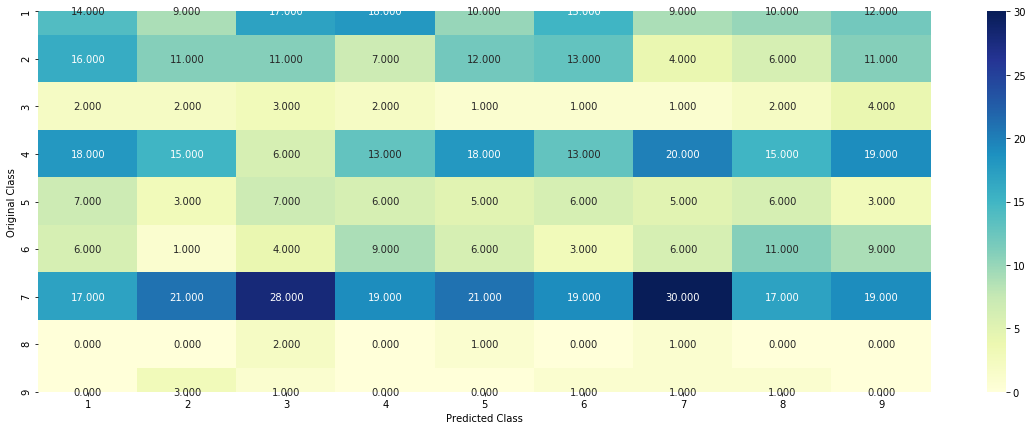

-------------------- Precision matrix (Columm Sum=1) --------------------


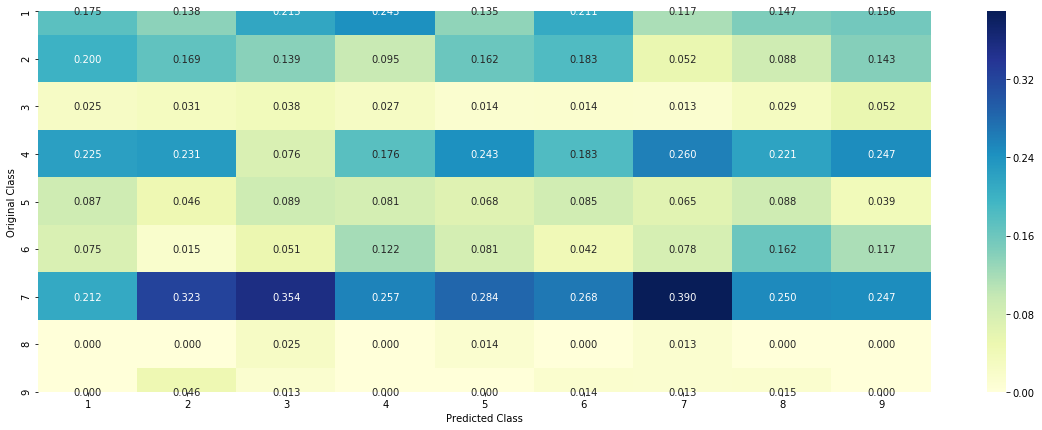

-------------------- Recall matrix (Row sum=1) --------------------


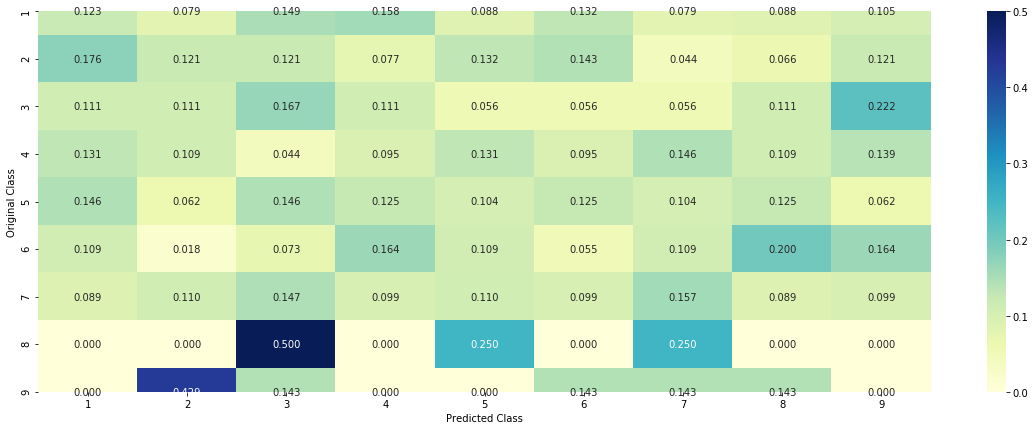

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

from sklearn.metrics.classification import log_loss

test_len = len(y_test)
predicted_y = np.zeros((test_len,9))
for i in range(test_len):
    rand_probs = np.random.rand(1,9)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

In [ ]:
train_gene_feature_onehotCoding.shape

(2124, 243)

In [ ]:
# one-hot encoding of variation feature.
variation_vectorizer =TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=1000)

train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [ ]:
# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
train_text_feature_onehotCoding.shape

(2124, 1000)

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1959)

In [ ]:
#normalize gene and variation

train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)

test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)

cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = X_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = X_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cv gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_cv))


In [ ]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))
# cv gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_cv))

In [ ]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [ ]:
train_gene_feature_responseCoding = normalize(train_gene_feature_responseCoding, axis=0)
test_gene_feature_responseCoding = normalize(test_gene_feature_responseCoding, axis=0)
cv_gene_feature_responseCoding = normalize(cv_gene_feature_responseCoding, axis=0)

train_variation_feature_responseCoding = normalize(train_variation_feature_responseCoding, axis=0)
test_variation_feature_responseCoding = normalize(test_variation_feature_responseCoding, axis=0)
cv_variation_feature_responseCoding = normalize(cv_variation_feature_responseCoding, axis=0)

train_text_feature_responseCoding = normalize(train_text_feature_responseCoding, axis=0)
test_text_feature_responseCoding = normalize(test_text_feature_responseCoding, axis=0)
cv_text_feature_responseCoding = normalize(cv_text_feature_responseCoding, axis=0)

In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()



train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cv data = ", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3202)
(number of data points * number of features) in test data =  (665, 3202)
(number of data points * number of features) in cv data =  (532, 3202)


In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cv data = ", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cv data =  (532, 27)


<h1>4. Machine Learning Models</h1>

In [ ]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

for alpha = 1e-05
Log Loss : 1.1713868204274953
for alpha = 0.0001
Log Loss : 1.1673059227455023
for alpha = 0.001
Log Loss : 1.1614972845601743
for alpha = 0.1
Log Loss : 1.2227170563901364
for alpha = 1
Log Loss : 1.5033763293157079
for alpha = 10
Log Loss : 1.9135247260702677
for alpha = 100
Log Loss : 1.856261280260445
for alpha = 1000
Log Loss : 1.8083209496087704


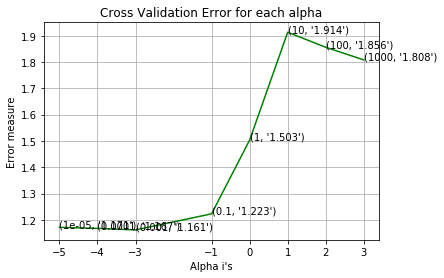

For values of best alpha =  0.001 The train log loss is: 0.47452413995146225
For values of best alpha =  0.001 The cross validation log loss is: 1.1614972845601743
For values of best alpha =  0.001 The test log loss is: 1.2363863312473


In [ ]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.1614972845601743
Number of missclassified point : 0.3890977443609023
-------------------- Confusion matrix --------------------


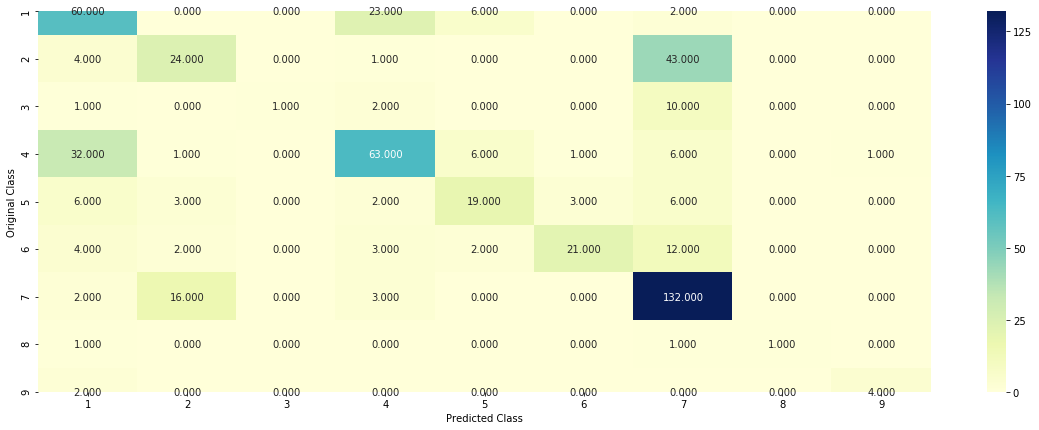

-------------------- Precision matrix (Columm Sum=1) --------------------


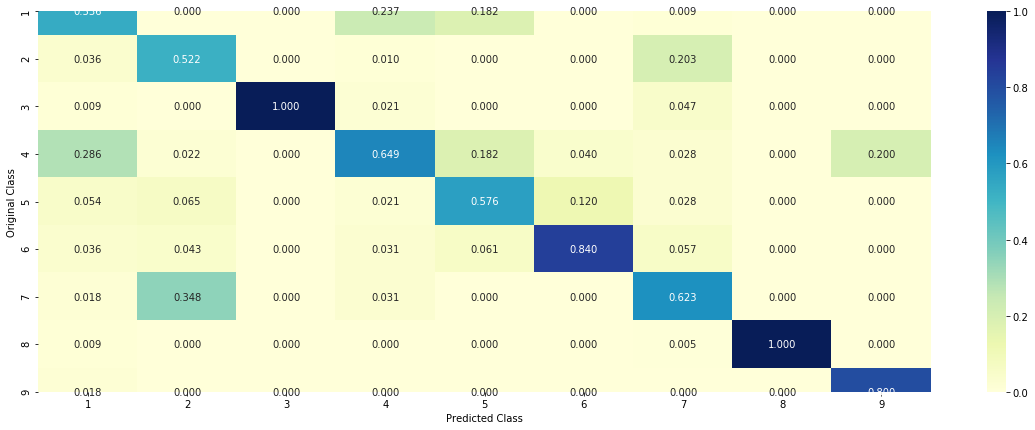

-------------------- Recall matrix (Row sum=1) --------------------


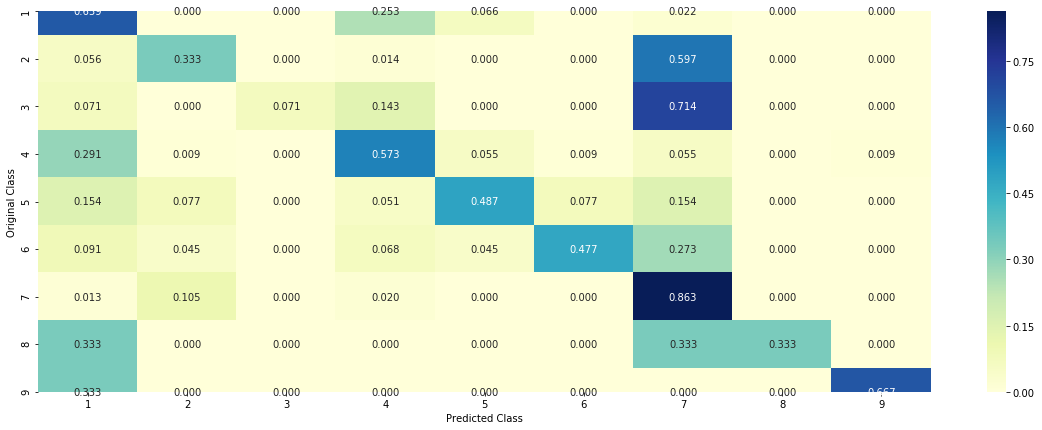

In [ ]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_cv, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- y_cv))/y_cv.shape[0])
plot_confusion_matrix(y_cv, sig_clf.predict(cv_x_onehotCoding.toarray()))

Log Loss : 1.2363863312473
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


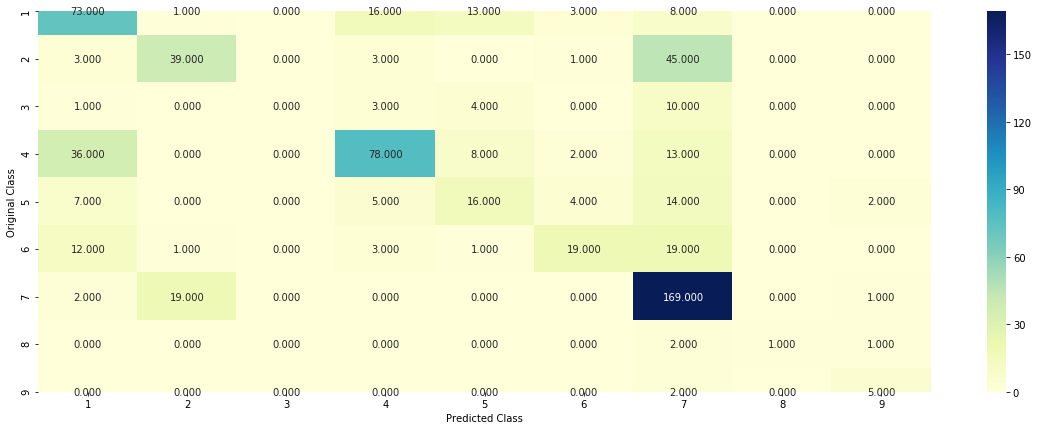

-------------------- Precision matrix (Columm Sum=1) --------------------


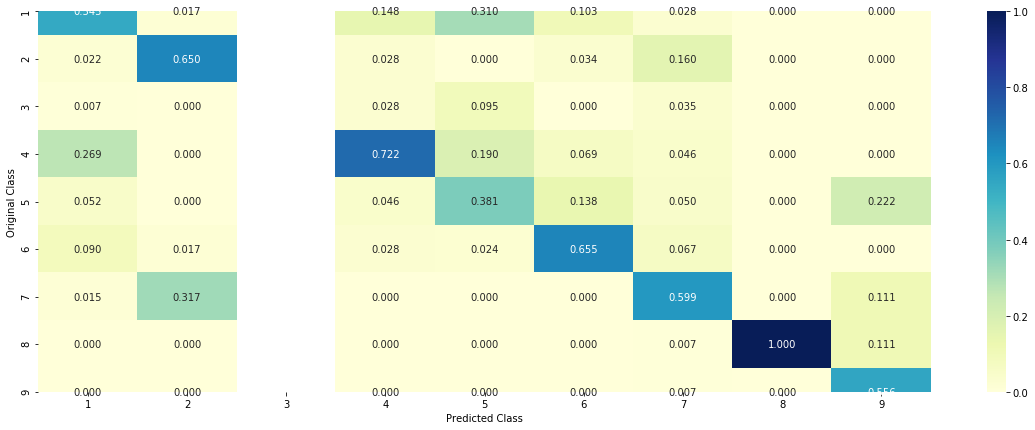

-------------------- Recall matrix (Row sum=1) --------------------


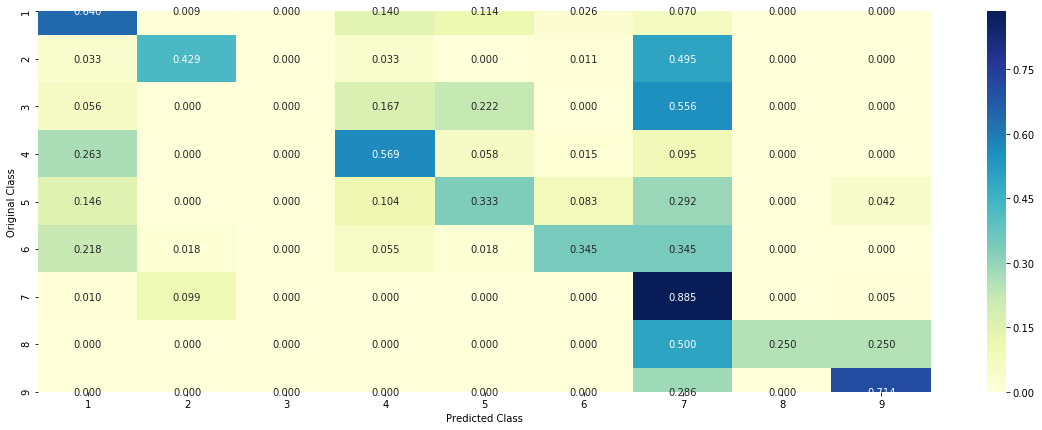

In [ ]:
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sig_clf.predict(test_x_onehotCoding.toarray()))

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1005 0.0555 0.0109 0.1128 0.0309 0.0293 0.655  0.0029 0.0021]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.4991314988484563
for alpha = 11
Log Loss : 1.515991016947385
for alpha = 15
Log Loss : 1.4499234593009525
for alpha = 21
Log Loss : 1.3900456389596305
for alpha = 31
Log Loss : 1.3594455308865228
for alpha = 41
Log Loss : 1.3560672074851203
for alpha = 51
Log Loss : 1.3563539790640817
for alpha = 99
Log Loss : 1.3679924755500377


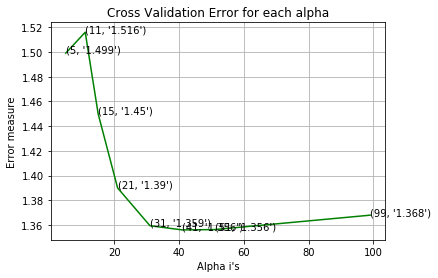

For values of best alpha =  41 The train log loss is: 0.8342361152486094
For values of best alpha =  41 The cross validation log loss is: 1.3560672074851203
For values of best alpha =  41 The test log loss is: 1.425584093516874


In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.3560672074851203
Number of mis-classified points : 0.5469924812030075
-------------------- Confusion matrix --------------------


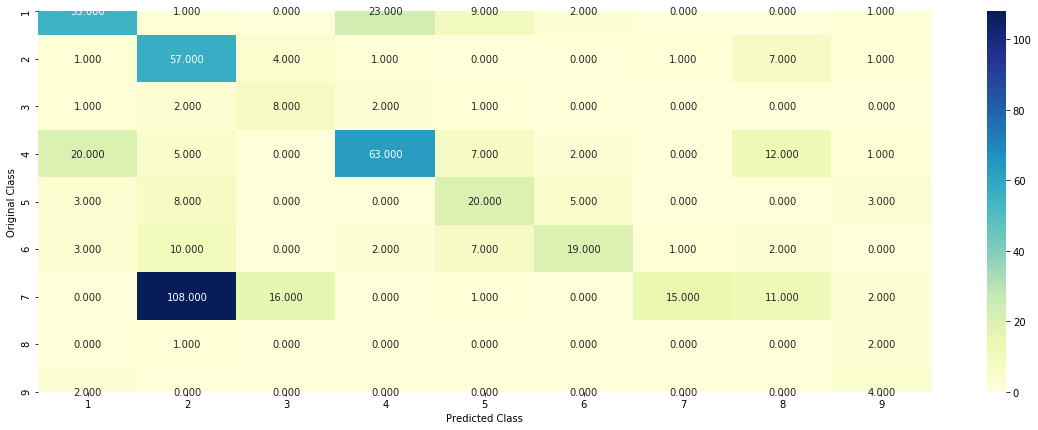

-------------------- Precision matrix (Columm Sum=1) --------------------


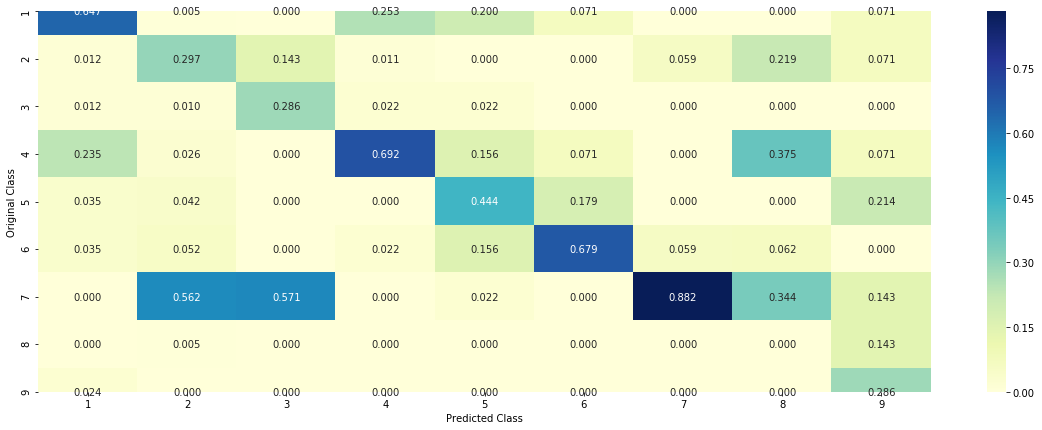

-------------------- Recall matrix (Row sum=1) --------------------


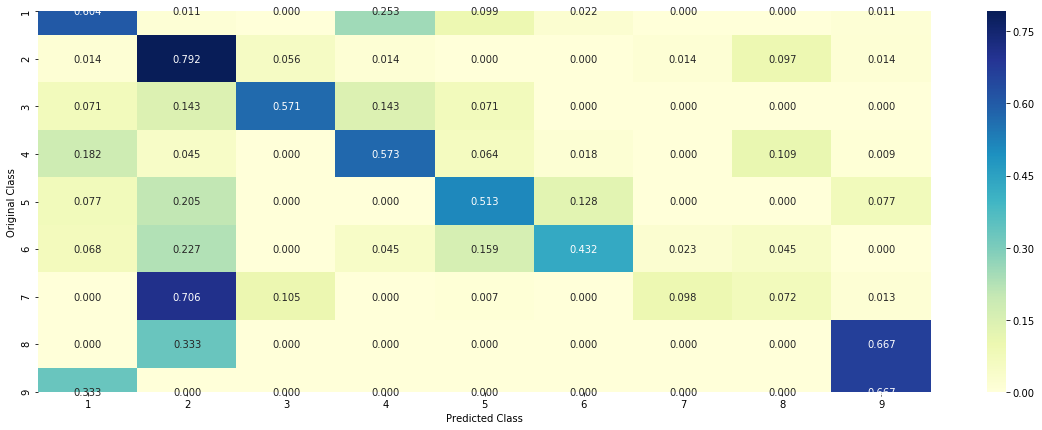

In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train, cv_x_responseCoding, y_cv, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", y_test[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))



Predicted Class : 4
Actual Class : 5
The  41  nearest neighbours of the test points belongs to classes [1 1 2 4 1 3 5 3 3 4 2 6 1 1 1 1 2 4 3 5 4 4 4 7 1 4 2 1 4 2 7 7 1 4 2 1 3
 4 6 4 4]
Fequency of nearest points : Counter({4: 12, 1: 11, 2: 6, 3: 5, 7: 3, 5: 2, 6: 2})


<h3>4.2.4. Sample Query Point-2 </h3>

In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", y_test[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))


Predicted Class : 2
Actual Class : 8
The  41  nearest neighbours of the test points belongs to classes [7 2 1 8 1 1 2 4 8 2 7 2 7 8 8 4 7 2 7 3 7 8 2 7 1 8 7 2 4 2 2 4 2 7 7 2 7
 2 2 2 2]
Fequency of nearest points : Counter({2: 15, 7: 11, 8: 6, 1: 4, 4: 4, 3: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.1120887219712476
for alpha = 1e-05
Log Loss : 1.1193312404697209
for alpha = 0.0001
Log Loss : 1.1415048701718042
for alpha = 0.001
Log Loss : 1.2421094143241325
for alpha = 0.01
Log Loss : 1.7748180991243918
for alpha = 0.1
Log Loss : 2.0403103952701347
for alpha = 1
Log Loss : 2.0689444615070247
for alpha = 10
Log Loss : 2.0716400854690913
for alpha = 100
Log Loss : 2.0719558579590216


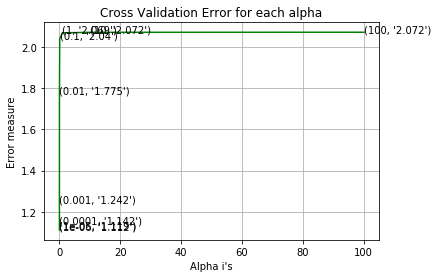

For values of best alpha =  1e-06 The train log loss is: 0.4565205422998572
For values of best alpha =  1e-06 The cross validation log loss is: 1.1120887219712476
For values of best alpha =  1e-06 The test log loss is: 1.1374511695914966


In [ ]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.1120887219712476
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


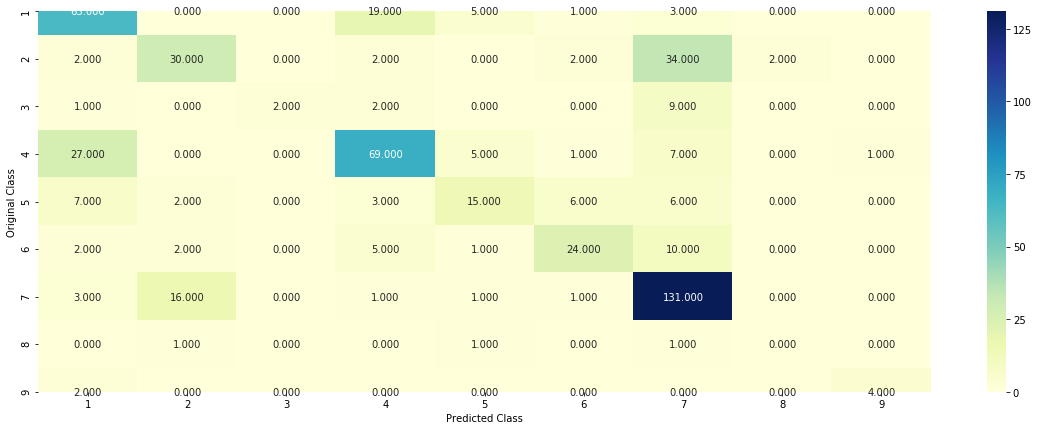

-------------------- Precision matrix (Columm Sum=1) --------------------


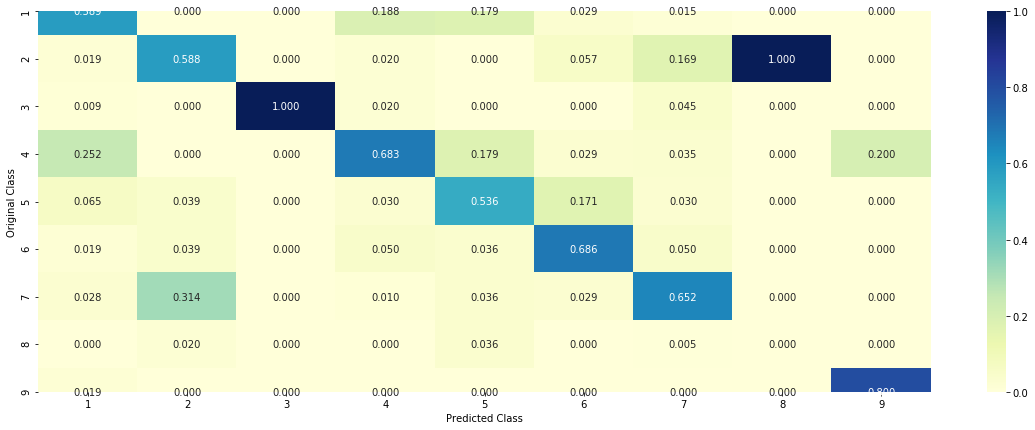

-------------------- Recall matrix (Row sum=1) --------------------


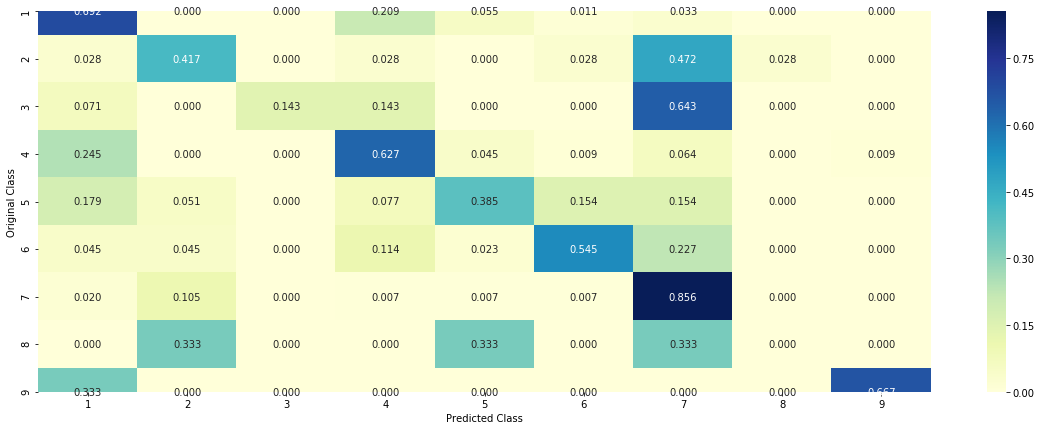

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_cv, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,y_train)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0496 0.0173 0.0169 0.2575 0.0342 0.0242 0.5951 0.0029 0.0023]]
Actual Class : 5
--------------------------------------------------
403 Text feature [0941] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0423 0.0777 0.0227 0.0576 0.0112 0.0026 0.7515 0.0265 0.0079]]
Actual Class : 8
--------------------------------------------------
55 Text feature [002] present in test data point [True]
154 Text feature [01] present in test data point [True]
427 Text feature [10ng] present in test data point [True]
428 Text feature [12ca5] present in test data point [True]
Out of the top  500  features  4 are present in query point


<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.1746927956488926
for alpha = 1e-05
Log Loss : 1.1605536886800047
for alpha = 0.0001
Log Loss : 1.1629338453940854
for alpha = 0.001
Log Loss : 1.4141506477441892
for alpha = 0.01
Log Loss : 2.0454541030090616
for alpha = 0.1
Log Loss : 2.164894484063444
for alpha = 1
Log Loss : 2.143393847642417


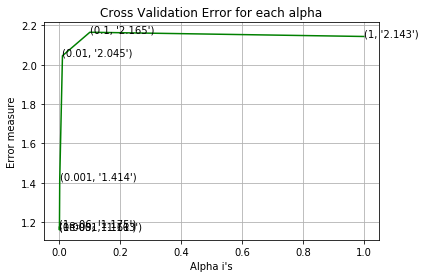

For values of best alpha =  1e-05 The train log loss is: 0.38708051111468766
For values of best alpha =  1e-05 The cross validation log loss is: 1.1605536886800047
For values of best alpha =  1e-05 The test log loss is: 1.154673979710386


In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.1605536886800047
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


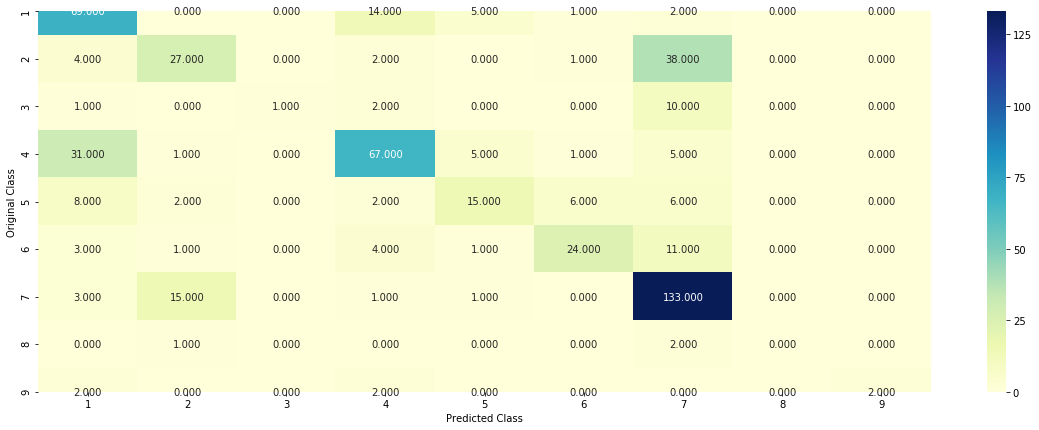

-------------------- Precision matrix (Columm Sum=1) --------------------


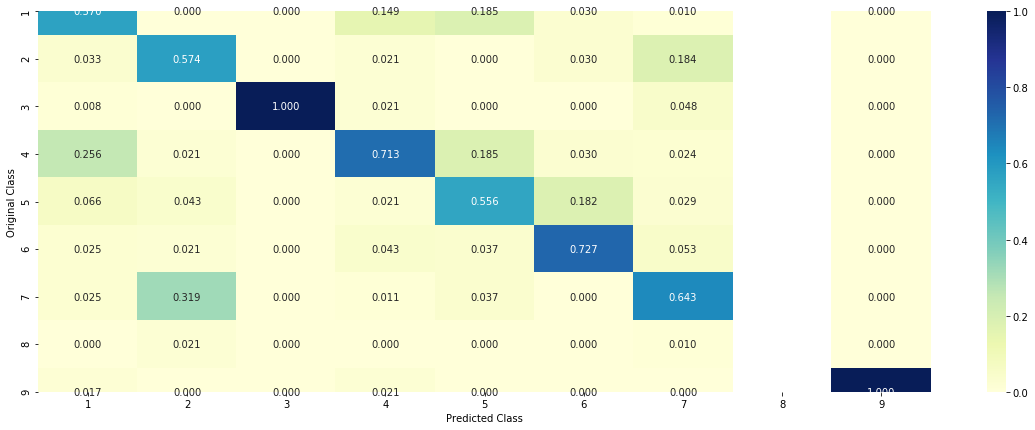

-------------------- Recall matrix (Row sum=1) --------------------


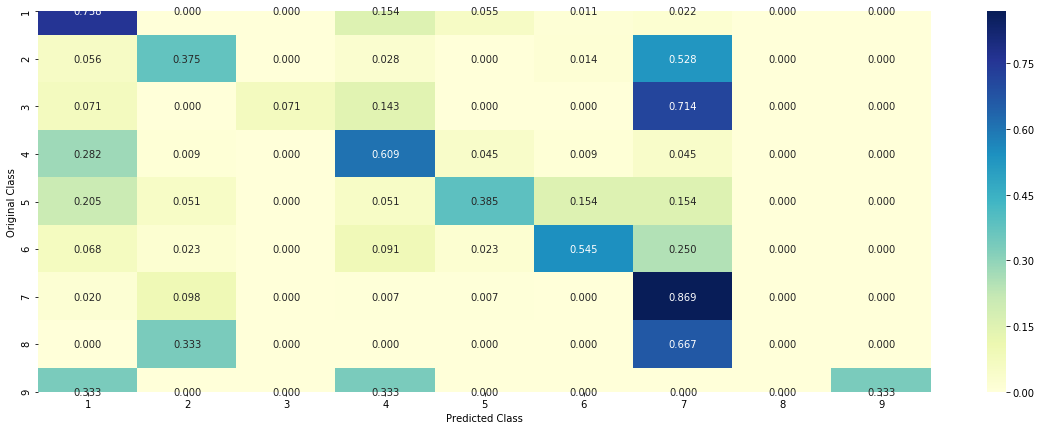

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_cv, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,y_train)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1046 0.0173 0.009  0.3515 0.0341 0.0255 0.4501 0.0053 0.0026]]
Actual Class : 5
--------------------------------------------------
395 Text feature [0941] present in test data point [True]
404 Text feature [10] present in test data point [True]
Out of the top  500  features  2 are present in query point


<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [ ]:

test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0612 0.3459 0.0007 0.0025 0.0049 0.0027 0.5773 0.0042 0.0006]]
Actual Class : 7
--------------------------------------------------
404 Text feature [10] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.1390718444648436
for C = 0.0001
Log Loss : 1.0653715982958913
for C = 0.001
Log Loss : 1.107061568154998
for C = 0.01
Log Loss : 1.2065775745814495
for C = 0.1
Log Loss : 2.031403370451304
for C = 1
Log Loss : 2.0720572657194096
for C = 10
Log Loss : 2.072056782211034
for C = 100
Log Loss : 2.0720572247150892


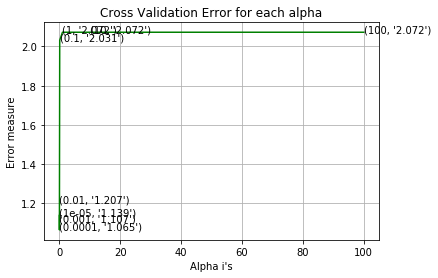

For values of best alpha =  0.0001 The train log loss is: 0.362288663590665
For values of best alpha =  0.0001 The cross validation log loss is: 1.0653715982958913
For values of best alpha =  0.0001 The test log loss is: 1.1125311459513954


In [ ]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.0653715982958913
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


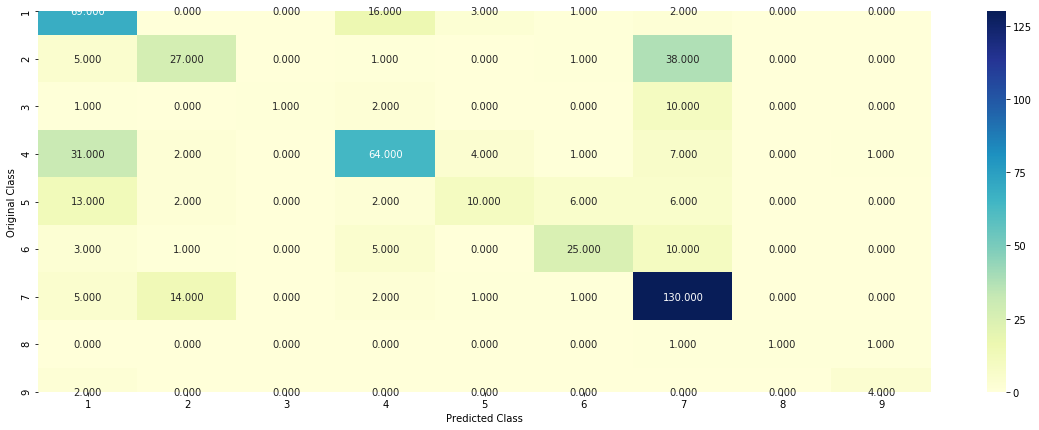

-------------------- Precision matrix (Columm Sum=1) --------------------


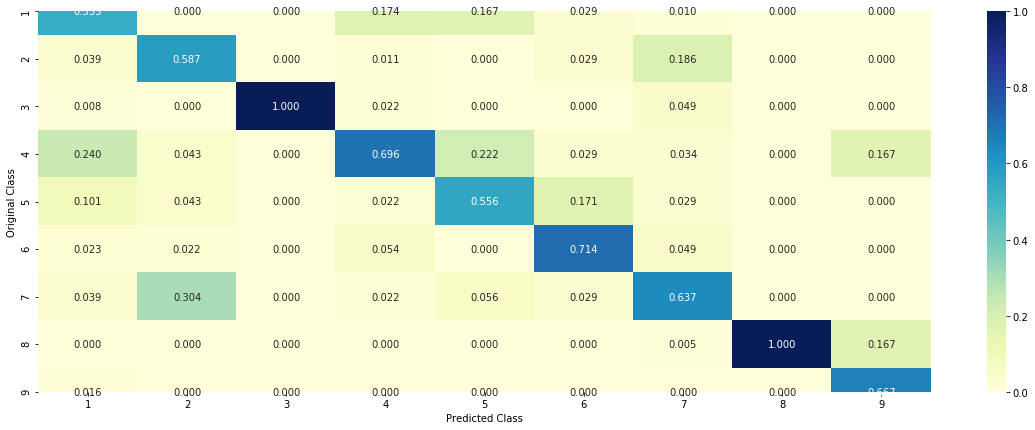

-------------------- Recall matrix (Row sum=1) --------------------


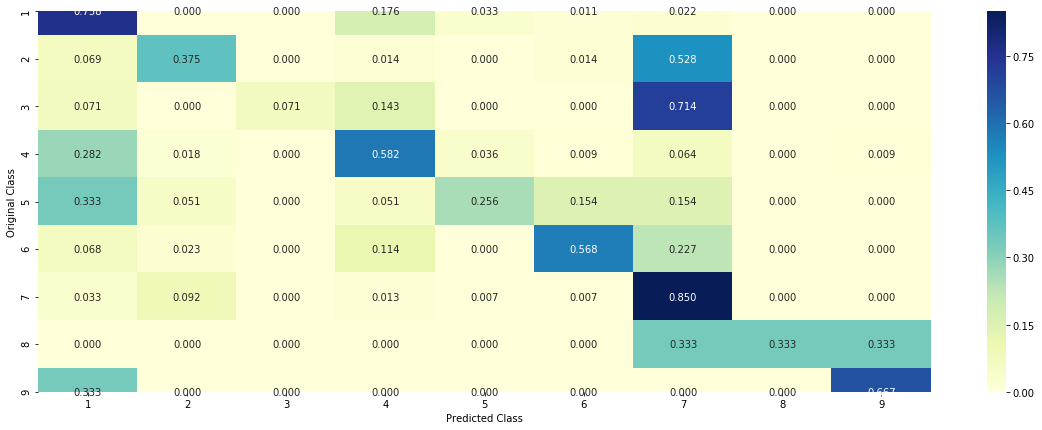

In [ ]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,cv_x_onehotCoding,y_cv, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,y_train)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1101 0.016  0.0096 0.4201 0.0331 0.0369 0.3691 0.0024 0.0027]]
Actual Class : 5
--------------------------------------------------
132 Text feature [106] present in test data point [True]
195 Text feature [11] present in test data point [True]
470 Text feature [108] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h4>4.3.3.2. For Incorrectly classified point</h4>

In [ ]:
test_point_index = 100
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0242 0.0326 0.0124 0.0466 0.012  0.0101 0.8402 0.0183 0.0037]]
Actual Class : 8
--------------------------------------------------
64 Text feature [01] present in test data point [True]
128 Text feature [002] present in test data point [True]
130 Text feature [10ng] present in test data point [True]
482 Text feature [10] present in test data point [True]
483 Text feature [12ca5] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1945826977095442
for n_estimators = 100 and max depth =  10
Log Loss : 1.2394323258902886
for n_estimators = 200 and max depth =  5
Log Loss : 1.1760452715023928
for n_estimators = 200 and max depth =  10
Log Loss : 1.2250407843408826
for n_estimators = 500 and max depth =  5
Log Loss : 1.1664830856958974
for n_estimators = 500 and max depth =  10
Log Loss : 1.2192254540101244
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1617817919381395
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2188667618478888
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1625926191451659
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2192371271843438
For values of best estimator =  1000 The train log loss is: 0.8695080671151212
For values of best estimator =  1000 The cross validation log loss is: 1.1617817919381395
For values of best estimator =  1000 The test log loss is: 1.2059294439390496


<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1617817919381395
Number of mis-classified points : 0.40977443609022557
-------------------- Confusion matrix --------------------


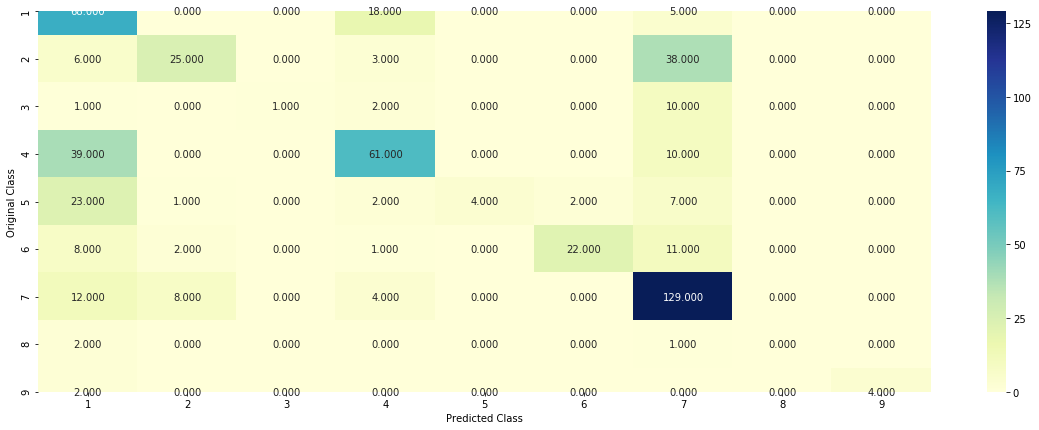

-------------------- Precision matrix (Columm Sum=1) --------------------


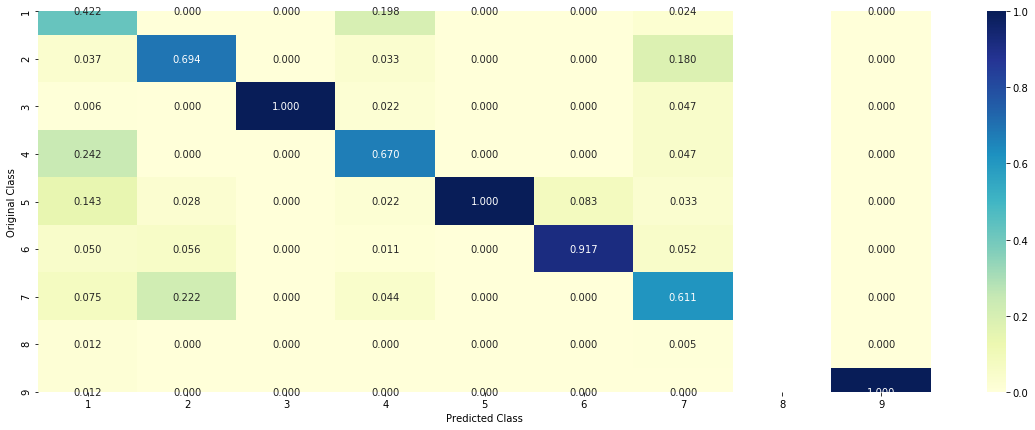

-------------------- Recall matrix (Row sum=1) --------------------


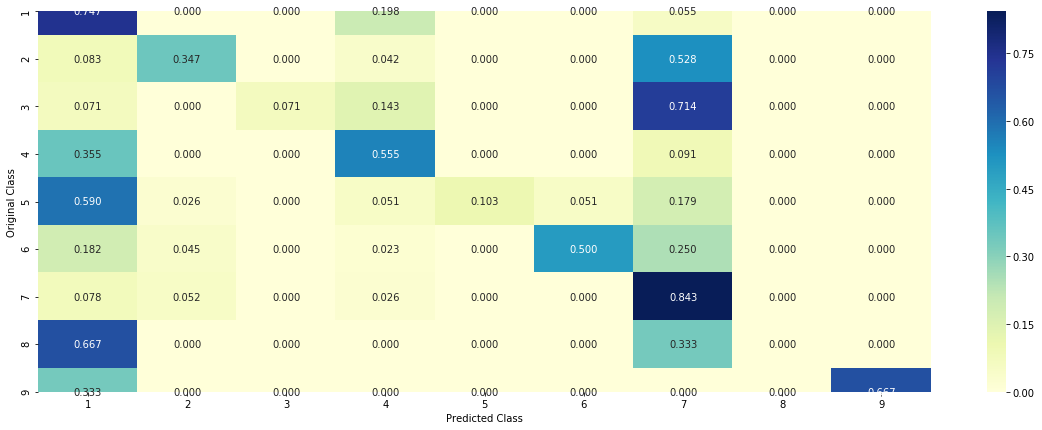

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,cv_x_onehotCoding,y_cv, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

In [ ]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0652 0.1441 0.0206 0.0782 0.0532 0.0411 0.5894 0.005  0.0032]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h4>4.5.3.2. Inorrectly Classified point</h4>

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0382 0.1069 0.0193 0.0522 0.0417 0.0334 0.6944 0.0069 0.0071]]
Actuall Class : 8
--------------------------------------------------
1 Text feature [002] present in test data point [True]
Out of the top  100  features  1 are present in query point


<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.983625715280103
for n_estimators = 10 and max depth =  3
Log Loss : 3.760820488407212
for n_estimators = 10 and max depth =  5
Log Loss : 2.3912069226008135
for n_estimators = 10 and max depth =  10
Log Loss : 1.9670576536444946
for n_estimators = 50 and max depth =  2
Log Loss : 2.9331913888148375
for n_estimators = 50 and max depth =  3
Log Loss : 3.057518571571248
for n_estimators = 50 and max depth =  5
Log Loss : 2.0243700362654122
for n_estimators = 50 and max depth =  10
Log Loss : 1.8864700502284506
for n_estimators = 100 and max depth =  2
Log Loss : 2.651547658020557
for n_estimators = 100 and max depth =  3
Log Loss : 2.4646922128725883
for n_estimators = 100 and max depth =  5
Log Loss : 1.9778040063532427
for n_estimators = 100 and max depth =  10
Log Loss : 1.886591533296534
for n_estimators = 200 and max depth =  2
Log Loss : 2.419690668017708
for n_estimators = 200 and max depth =  3
Log Loss : 2.2646441438405343
for

<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.8397039760197746
Number of mis-classified points : 0.7857142857142857
-------------------- Confusion matrix --------------------


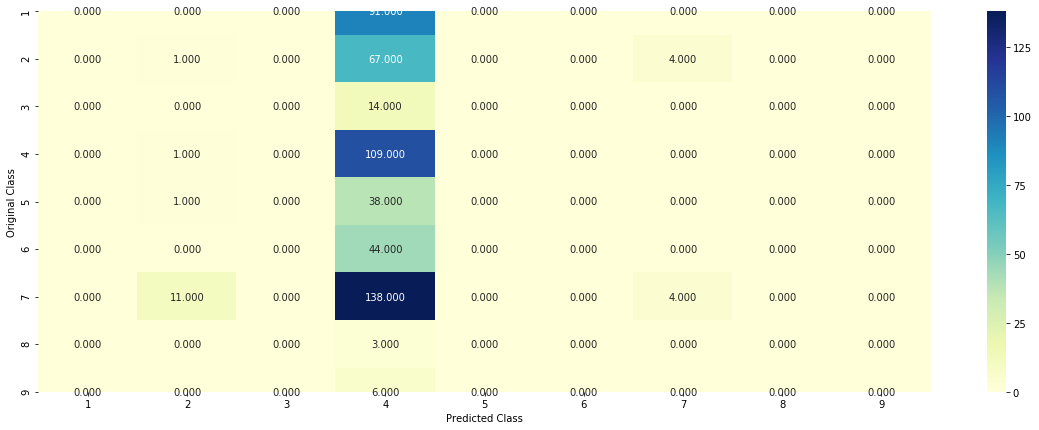

-------------------- Precision matrix (Columm Sum=1) --------------------


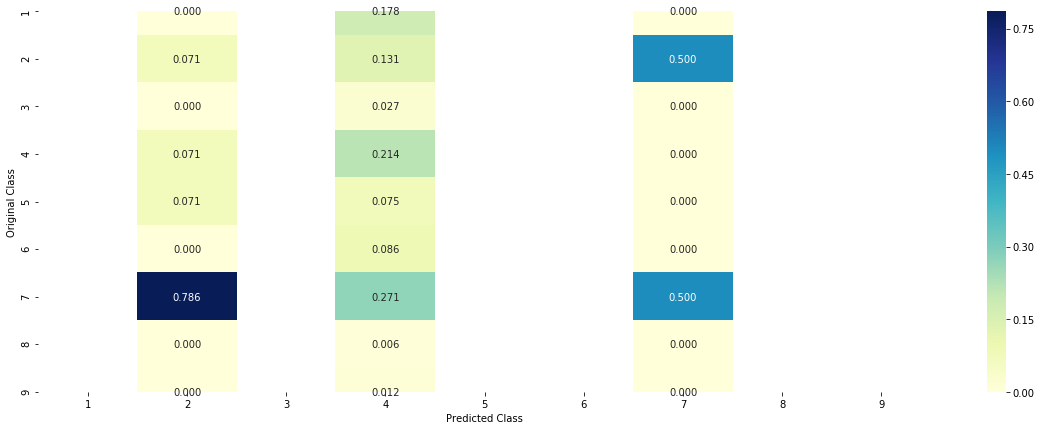

-------------------- Recall matrix (Row sum=1) --------------------


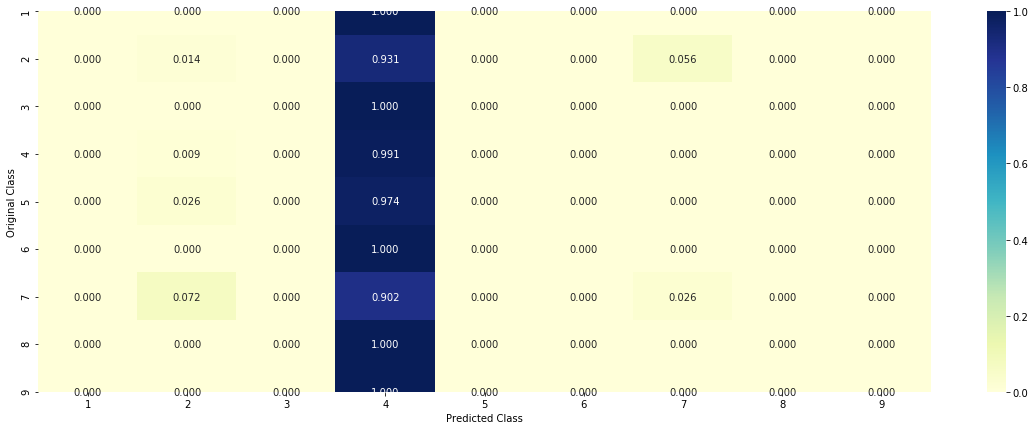

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train,cv_x_responseCoding,y_cv, clf)

<h3>4.5.5. Feature Importance</h3>

<h4>4.5.5.1. Correctly Classified point</h4>

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.149  0.2097 0.0153 0.27   0.0386 0.0663 0.2202 0.0167 0.0142]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h4>4.5.5.2. Incorrectly Classified point</h4>

In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1516 0.2103 0.0155 0.2455 0.0388 0.0672 0.2377 0.0189 0.0144]]
Actual Class : 8
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h2>4.7 Stack the models </h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.24
Support vector machines : Log Loss: 2.07
Naive Bayes : Log Loss: 1.16
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.032
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.505
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.211
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.442
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.845


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.49067332767477645
Log loss (CV) on the stacking classifier : 1.2111852598668622
Log loss (test) on the stacking classifier : 1.2497774300169633
Number of missclassified point : 0.38646616541353385
-------------------- Confusion matrix --------------------


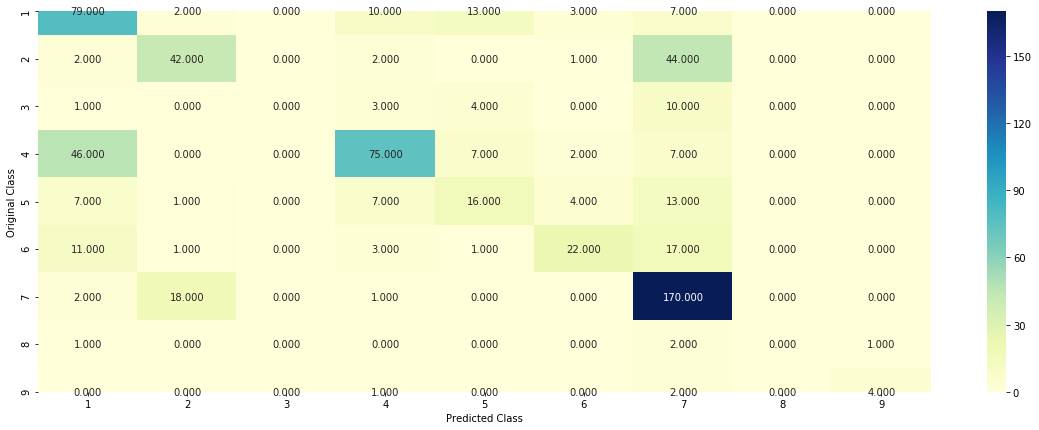

-------------------- Precision matrix (Columm Sum=1) --------------------


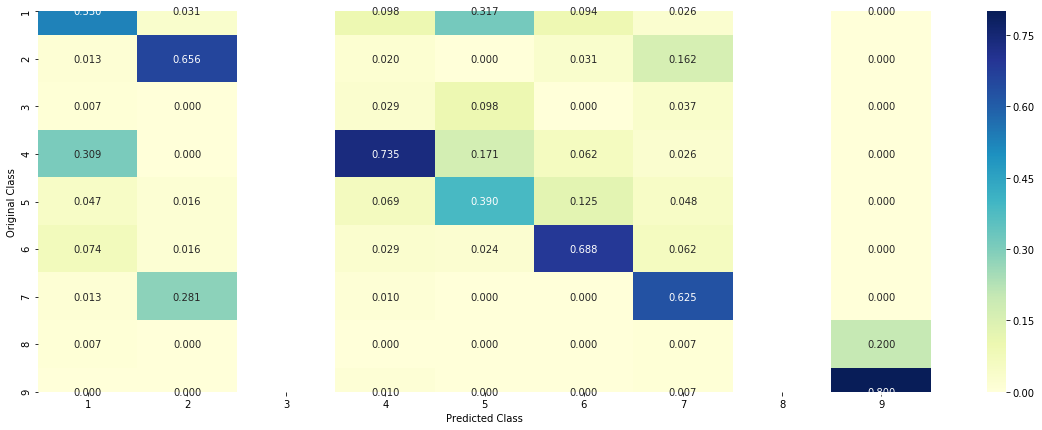

-------------------- Recall matrix (Row sum=1) --------------------


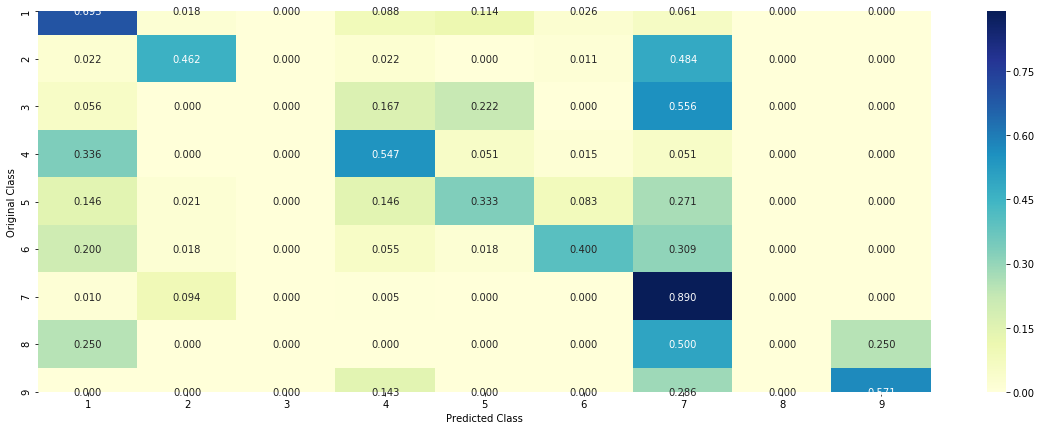

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(y_train, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=sclf.predict(test_x_onehotCoding))

<h3>4.7.3 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8327237943562267
Log loss (CV) on the VotingClassifier : 1.2734962233927185
Log loss (test) on the VotingClassifier : 1.3049208352946347
Number of missclassified point : 0.39398496240601505
-------------------- Confusion matrix --------------------


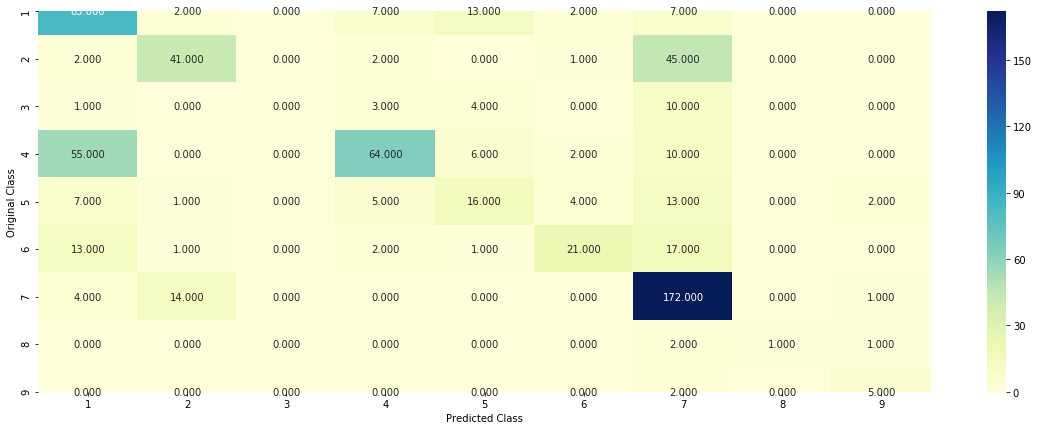

-------------------- Precision matrix (Columm Sum=1) --------------------


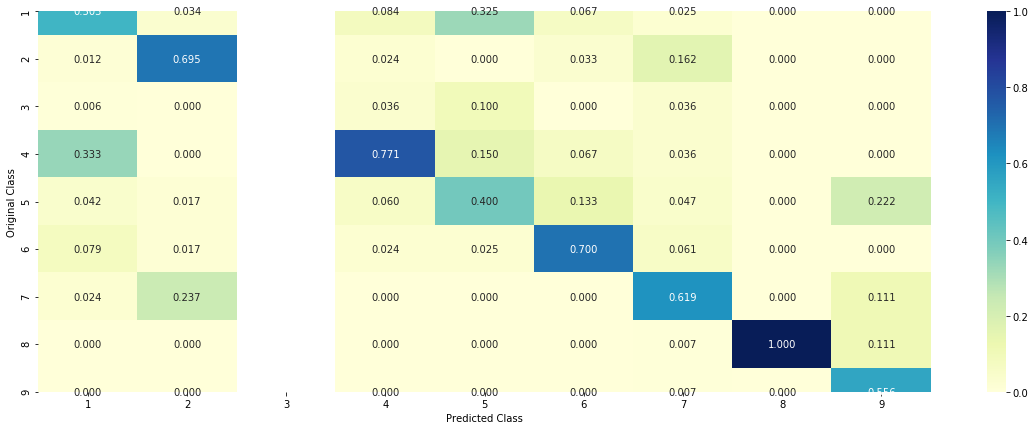

-------------------- Recall matrix (Row sum=1) --------------------


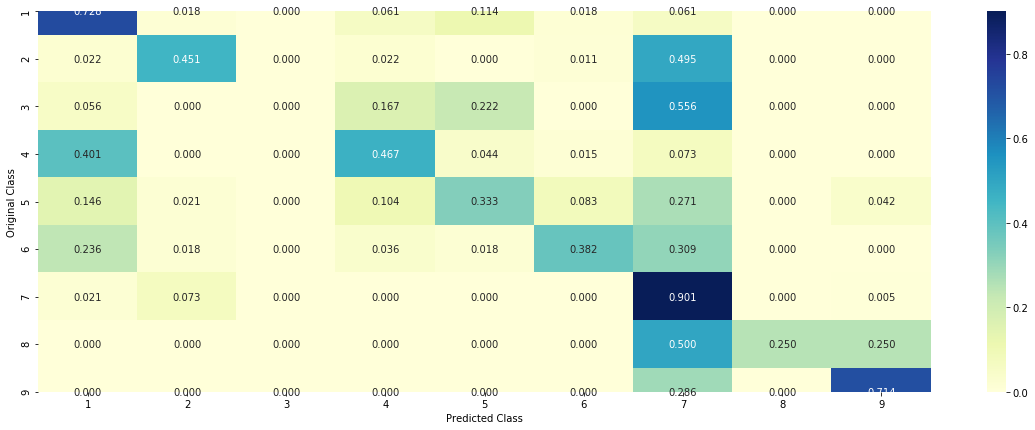

In [ ]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=vclf.predict(test_x_onehotCoding))

<h2>Linear SVM</h2>

In [ ]:
def apply_LinearSVM(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding):

    alpha = [10 ** x for x in range(-6, 3)]
    cv_log_error_array = []
    for i in alpha:
        print("for alpha =", i)
        clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(train_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
    predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_cv, clf)

Total number of unique words in train data : 780068
for alpha = 1e-06
Log Loss : 1.5479930566257072
for alpha = 1e-05
Log Loss : 1.5117580992041635
for alpha = 0.0001
Log Loss : 1.5011646084964585
for alpha = 0.001
Log Loss : 1.4134794516822282
for alpha = 0.01
Log Loss : 1.21758484721544
for alpha = 0.1
Log Loss : 1.237030479873018
for alpha = 1
Log Loss : 1.3095722805843588
for alpha = 10
Log Loss : 1.3639935735156343
for alpha = 100
Log Loss : 1.3665584526114636


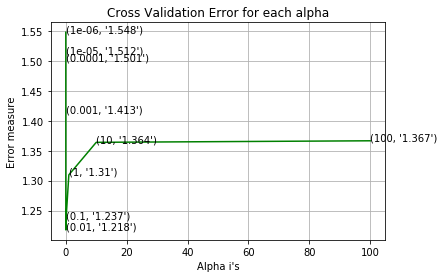

For values of best alpha =  0.01 The train log loss is: 0.827491634120063
For values of best alpha =  0.01 The cross validation log loss is: 1.21758484721544
For values of best alpha =  0.01 The test log loss is: 1.2909656080922975
Log loss : 1.21758484721544
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


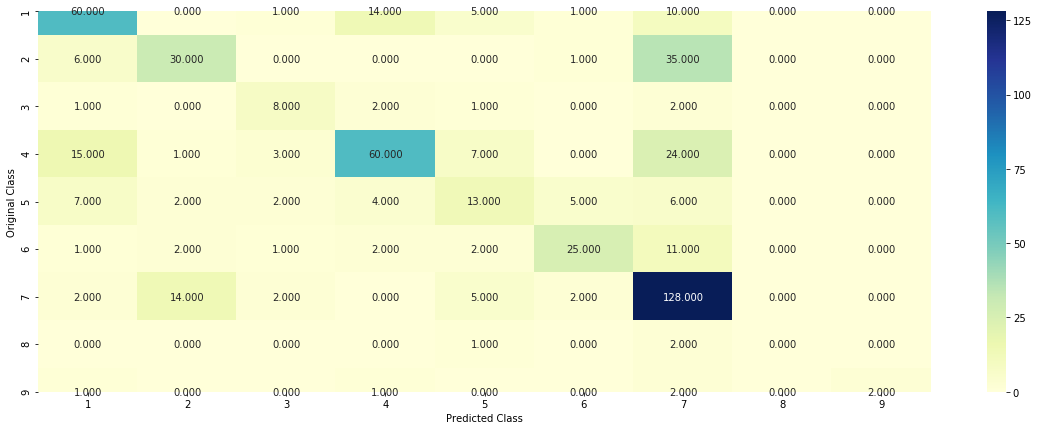

-------------------- Precision matrix (Columm Sum=1) --------------------


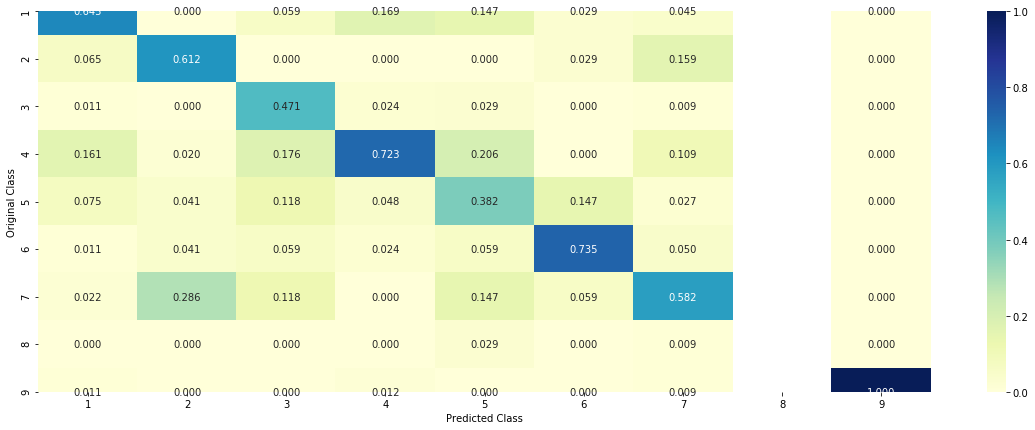

-------------------- Recall matrix (Row sum=1) --------------------


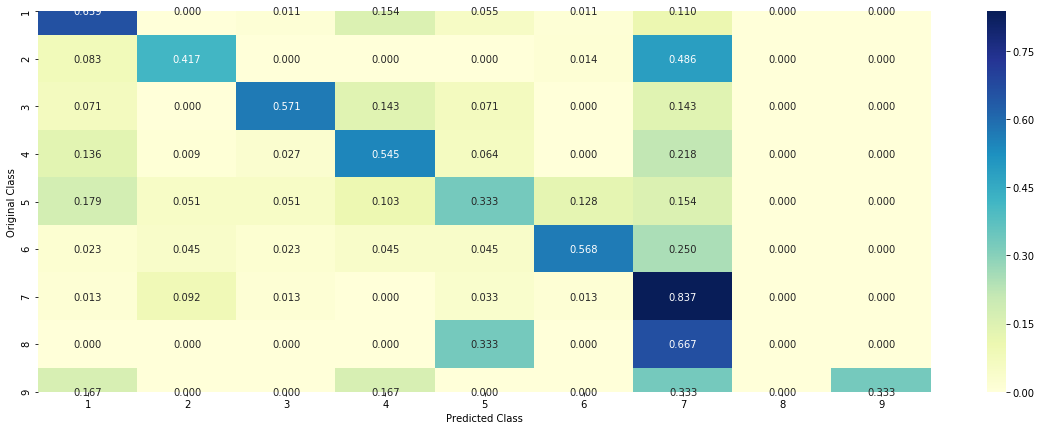

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = CountVectorizer(ngram_range=(1,2),min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_LinearSVM(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.3600830854505837
for alpha = 1e-05
Log Loss : 1.318104595653269
for alpha = 0.0001
Log Loss : 1.273206372625808
for alpha = 0.001
Log Loss : 1.1486049595610368
for alpha = 0.01
Log Loss : 1.1681651716156753
for alpha = 0.1
Log Loss : 1.4424285388197096
for alpha = 1
Log Loss : 1.7232407363084232
for alpha = 10
Log Loss : 1.7339913398729232
for alpha = 100
Log Loss : 1.7339913575542343


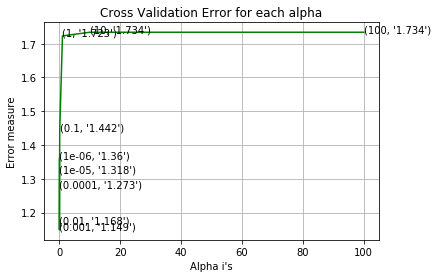

For values of best alpha =  0.001 The train log loss is: 0.6766389174399726
For values of best alpha =  0.001 The cross validation log loss is: 1.1486049595610368
For values of best alpha =  0.001 The test log loss is: 1.200187777274141
Log loss : 1.1486049595610368
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


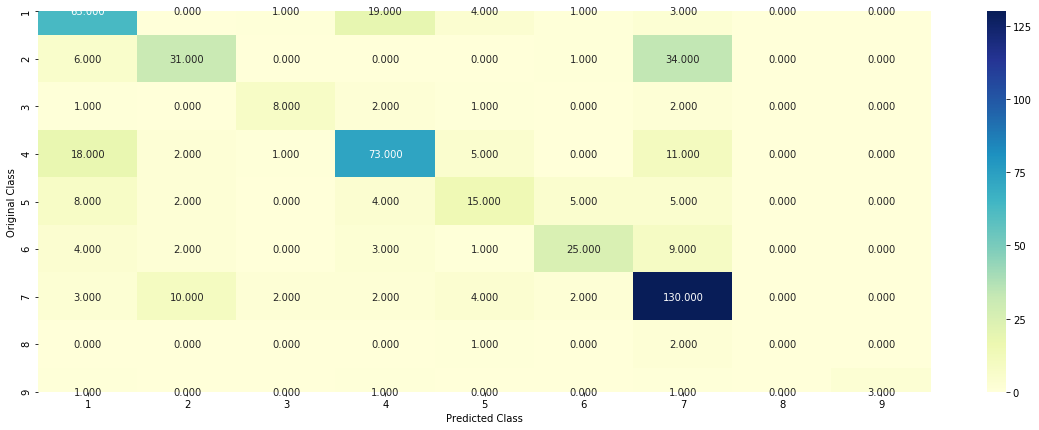

-------------------- Precision matrix (Columm Sum=1) --------------------


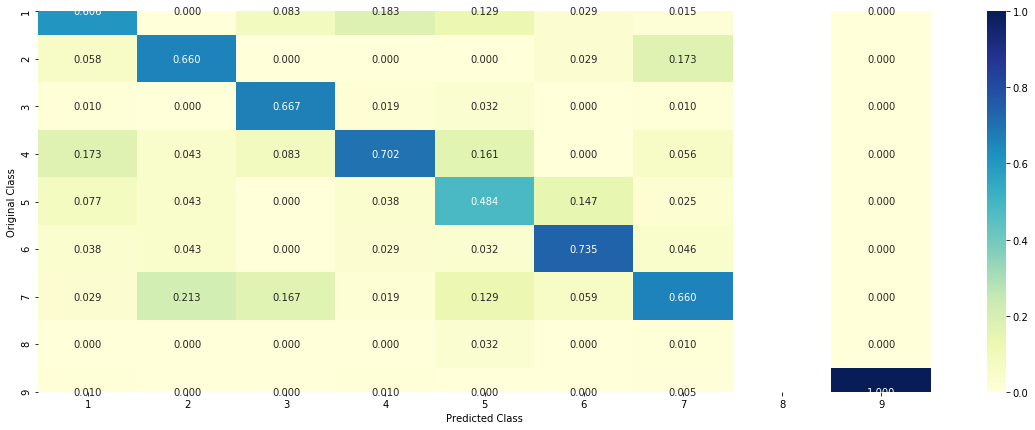

-------------------- Recall matrix (Row sum=1) --------------------


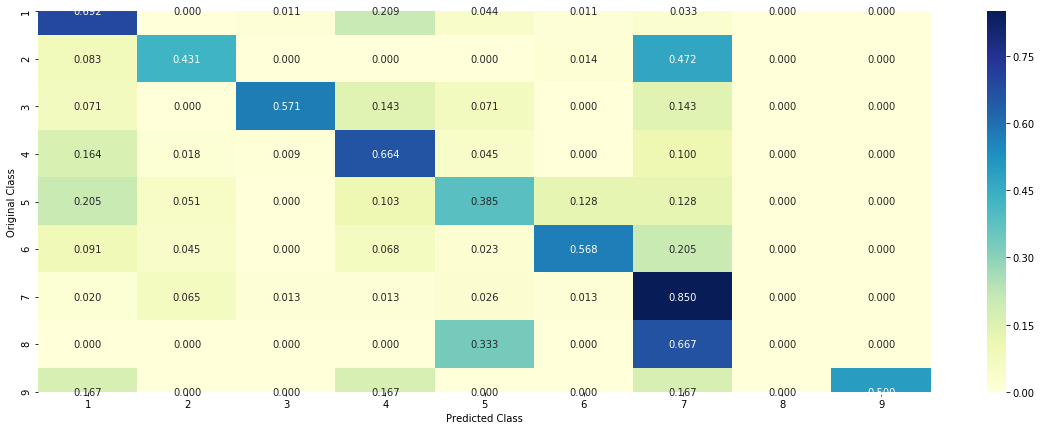

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = CountVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_LinearSVM(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.3139698833150988
for alpha = 1e-05
Log Loss : 1.3179564203799141
for alpha = 0.0001
Log Loss : 1.313596847555876
for alpha = 0.001
Log Loss : 1.1303149882506356
for alpha = 0.01
Log Loss : 1.14564838261879
for alpha = 0.1
Log Loss : 1.2683601384858842
for alpha = 1
Log Loss : 1.6007615066098095
for alpha = 10
Log Loss : 1.5983942941995135
for alpha = 100
Log Loss : 1.598394380549265


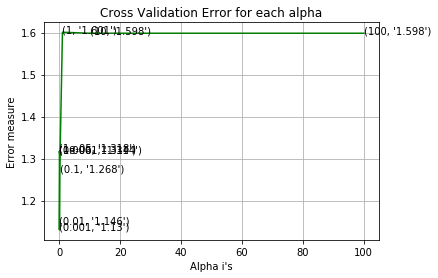

For values of best alpha =  0.001 The train log loss is: 0.6336627078133605
For values of best alpha =  0.001 The cross validation log loss is: 1.1303149882506356
For values of best alpha =  0.001 The test log loss is: 1.153102991521538
Log loss : 1.1303149882506356
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


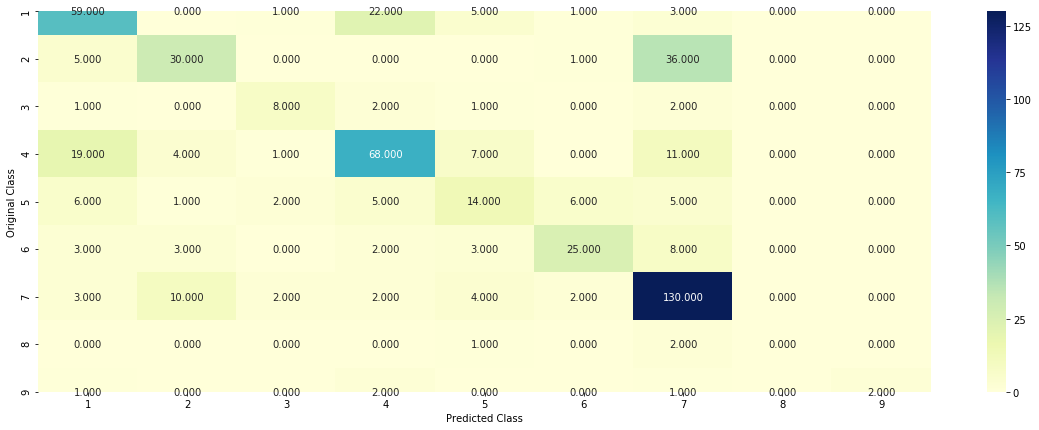

-------------------- Precision matrix (Columm Sum=1) --------------------


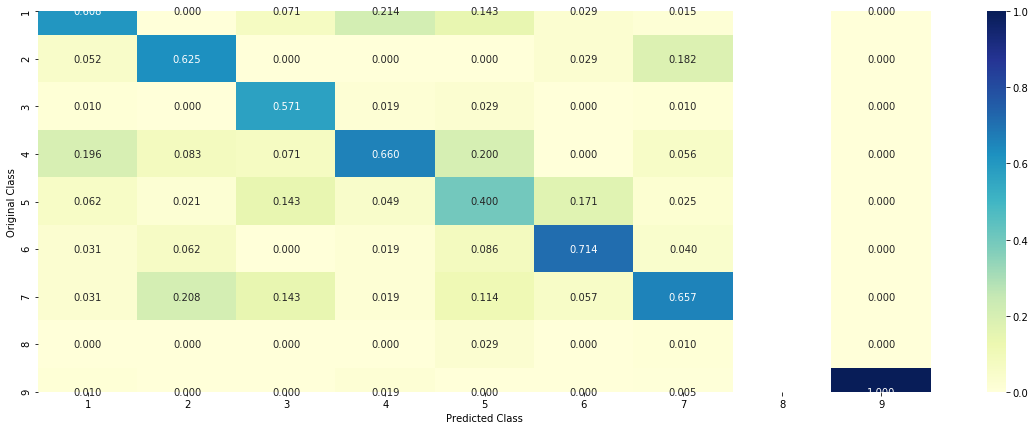

-------------------- Recall matrix (Row sum=1) --------------------


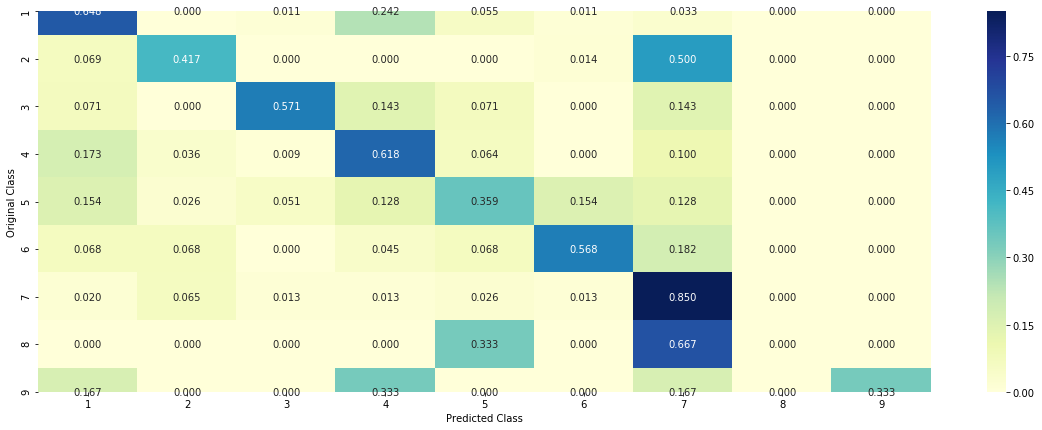

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_LinearSVM(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.3139722072492794
for alpha = 1e-05
Log Loss : 1.3179565517596716
for alpha = 0.0001
Log Loss : 1.314878500754574
for alpha = 0.001
Log Loss : 1.129537481067617
for alpha = 0.01
Log Loss : 1.1461772078742056
for alpha = 0.1
Log Loss : 1.2683169447692637
for alpha = 1
Log Loss : 1.6007614578463851
for alpha = 10
Log Loss : 1.5983942455668538
for alpha = 100
Log Loss : 1.5983943294313052


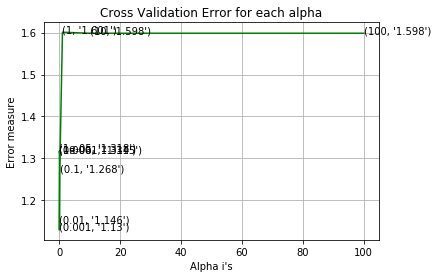

For values of best alpha =  0.001 The train log loss is: 0.6336559632403886
For values of best alpha =  0.001 The cross validation log loss is: 1.129537481067617
For values of best alpha =  0.001 The test log loss is: 1.152713059597109
Log loss : 1.129537481067617
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


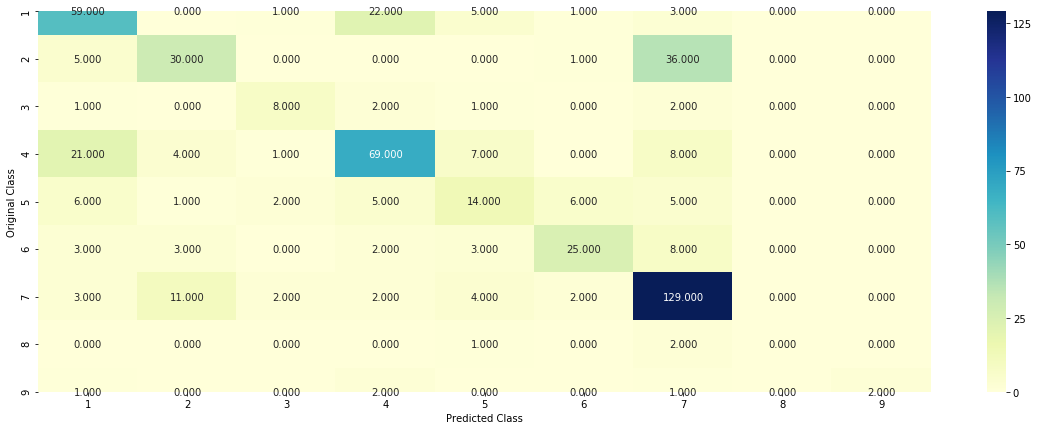

-------------------- Precision matrix (Columm Sum=1) --------------------


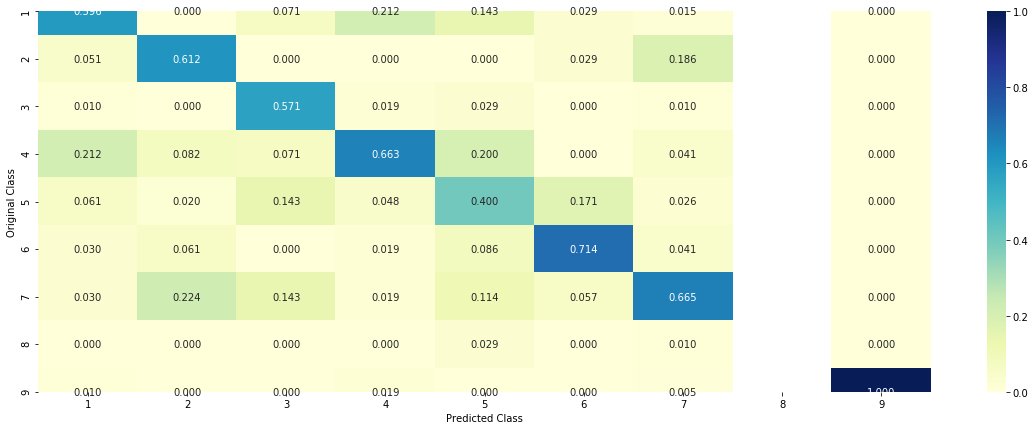

-------------------- Recall matrix (Row sum=1) --------------------


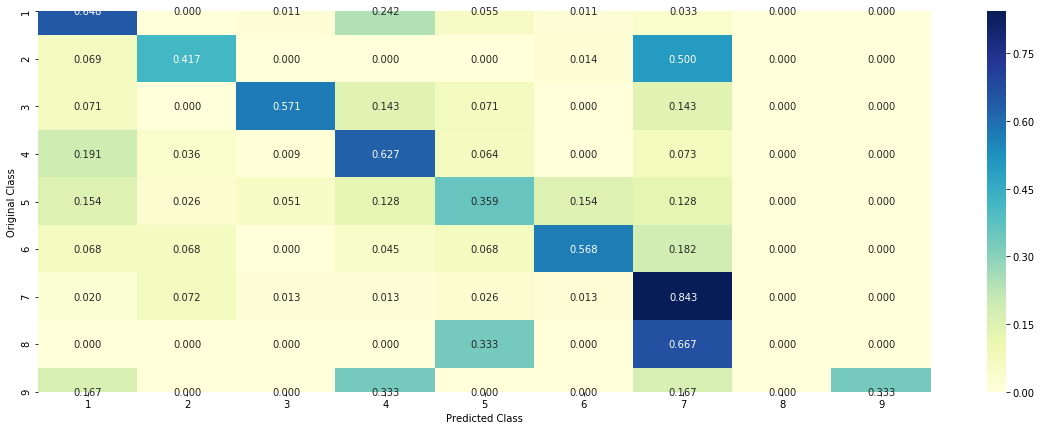

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_LinearSVM(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

<h2>Logistic Regression</h2>

In [ ]:
def vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer):
    
       
    train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
    test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
    cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

    # one-hot encoding of variation feature.
    
    train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
    test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
    cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

    # building a CountVectorizer with all the words that occured minimum 3 times in train data
    
    train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])

    # don't forget to normalize every feature
    train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

    # getting all the feature names (words)
    train_text_features= text_vectorizer.get_feature_names()

    # train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
    train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

    # zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
    text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


    print("Total number of unique words in train data :", len(train_text_features))

    # we use the same vectorizer that was trained on train data
    test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
    # don't forget to normalize every feature
    test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

    # we use the same vectorizer that was trained on train data
    cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
    # don't forget to normalize every feature
    cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

    #normalize gene and variation

    train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
    train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)

    test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
    test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)

    cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)
    cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)
    
    train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
    test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
    cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

    train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
    test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
    cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
    
    return train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding

In [ ]:
def apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding):

    alpha = [10 ** x for x in range(-6, 3)]
    cv_log_error_array = []
    for i in alpha:
        print("for alpha =", i)
        clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_error_array)
    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(train_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x_onehotCoding)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, cv_x_onehotCoding, y_cv, clf)

Total number of unique words in train data : 780068
for alpha = 1e-06
Log Loss : 1.5529054700504972
for alpha = 1e-05
Log Loss : 1.5299926290677897
for alpha = 0.0001
Log Loss : 1.4663459934752097
for alpha = 0.001
Log Loss : 1.1602340746844282
for alpha = 0.01
Log Loss : 1.1551877930490633
for alpha = 0.1
Log Loss : 1.202271647962667
for alpha = 1
Log Loss : 1.2901685856943228
for alpha = 10
Log Loss : 1.3506163770190986
for alpha = 100
Log Loss : 1.3645186395441602


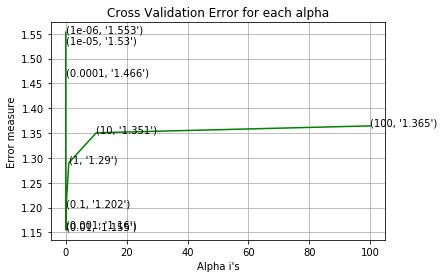

For values of best alpha =  0.01 The train log loss is: 0.7205159735098003
For values of best alpha =  0.01 The cross validation log loss is: 1.1551877930490633
For values of best alpha =  0.01 The test log loss is: 1.252543404691988
Log loss : 1.1551877930490633
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


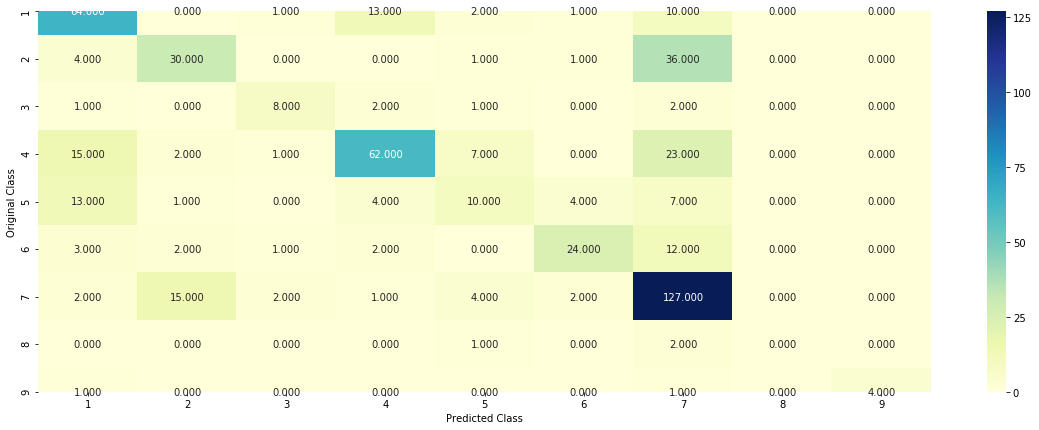

-------------------- Precision matrix (Columm Sum=1) --------------------


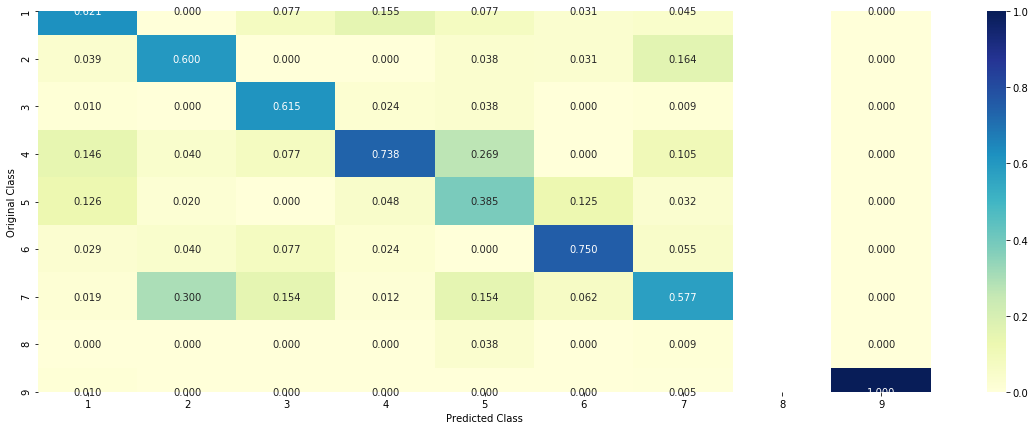

-------------------- Recall matrix (Row sum=1) --------------------


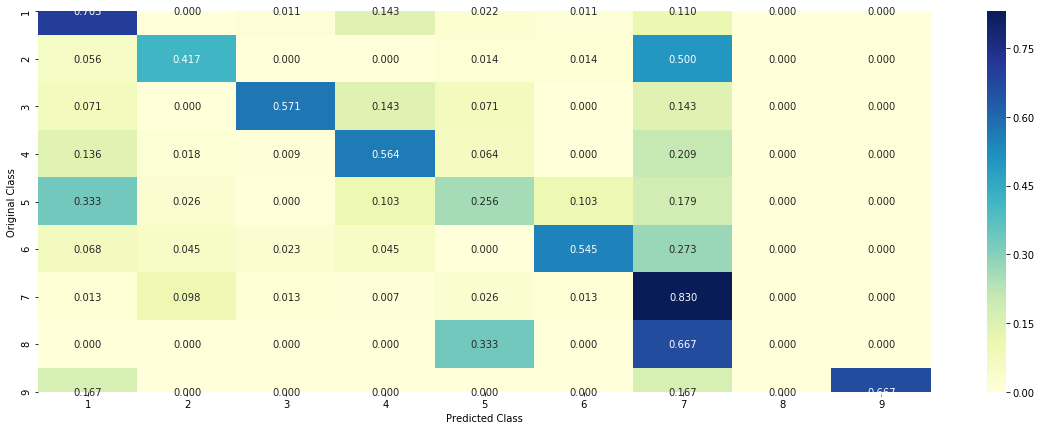

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = CountVectorizer(ngram_range=(1,2),min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.363208815328522
for alpha = 1e-05
Log Loss : 1.3163387331351921
for alpha = 0.0001
Log Loss : 1.1594210220187504
for alpha = 0.001
Log Loss : 1.1204904639816573
for alpha = 0.01
Log Loss : 1.1758011489732356
for alpha = 0.1
Log Loss : 1.5294384371253715
for alpha = 1
Log Loss : 1.710322394928276
for alpha = 10
Log Loss : 1.731418671177886
for alpha = 100
Log Loss : 1.733621802868771


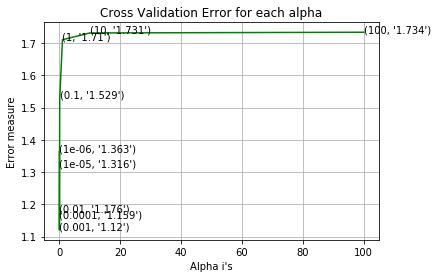

For values of best alpha =  0.001 The train log loss is: 0.6538495837668713
For values of best alpha =  0.001 The cross validation log loss is: 1.1204904639816573
For values of best alpha =  0.001 The test log loss is: 1.1781179566049895
Log loss : 1.1204904639816573
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


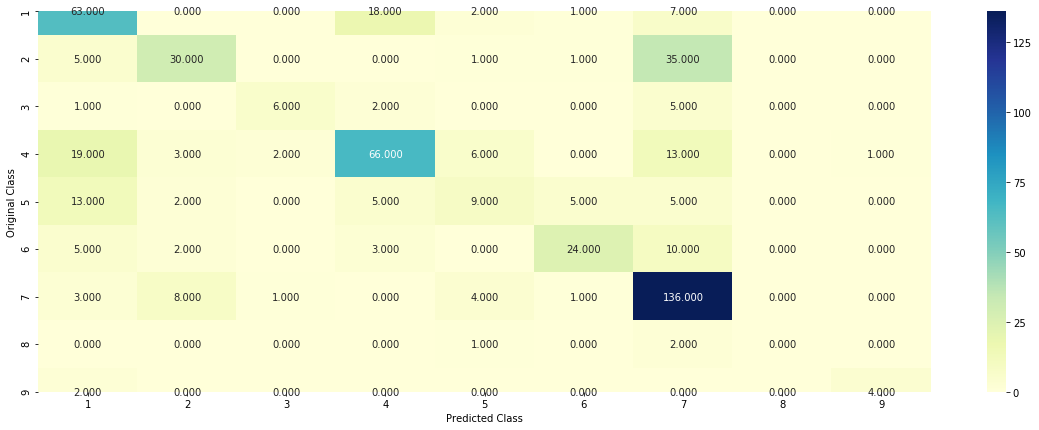

-------------------- Precision matrix (Columm Sum=1) --------------------


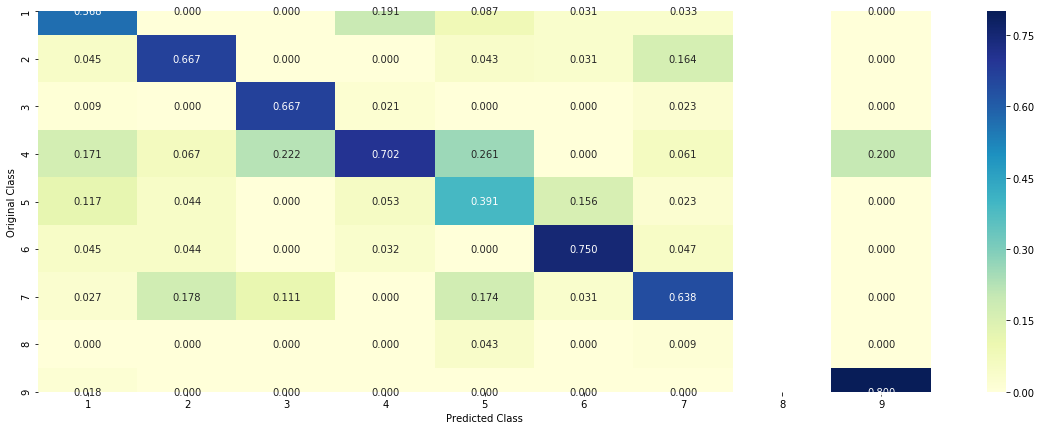

-------------------- Recall matrix (Row sum=1) --------------------


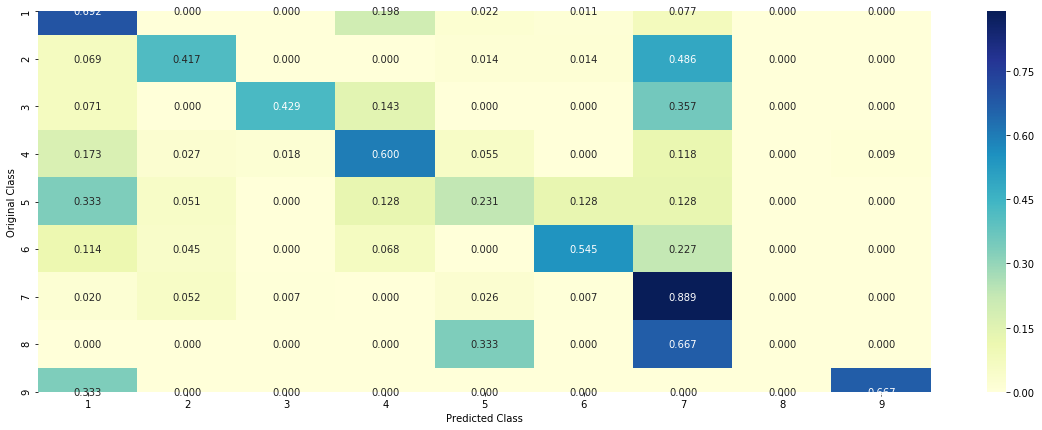

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = CountVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.3401459581432176
for alpha = 1e-05
Log Loss : 1.2794120878874
for alpha = 0.0001
Log Loss : 1.114846774245238
for alpha = 0.001
Log Loss : 1.0742786080173625
for alpha = 0.01
Log Loss : 1.1257676495108218
for alpha = 0.1
Log Loss : 1.3091649673184567
for alpha = 1
Log Loss : 1.5532102297318366
for alpha = 10
Log Loss : 1.5931592296310764
for alpha = 100
Log Loss : 1.5975081553839252


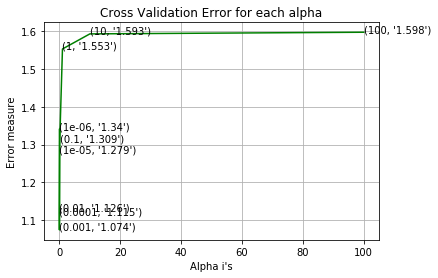

For values of best alpha =  0.001 The train log loss is: 0.5894115516163747
For values of best alpha =  0.001 The cross validation log loss is: 1.0742786080173625
For values of best alpha =  0.001 The test log loss is: 1.109270308990935
Log loss : 1.0742786080173625
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


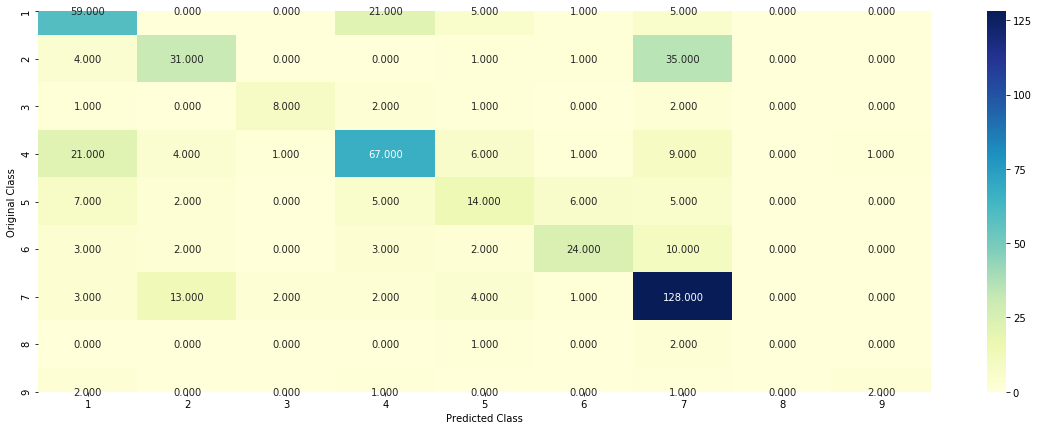

-------------------- Precision matrix (Columm Sum=1) --------------------


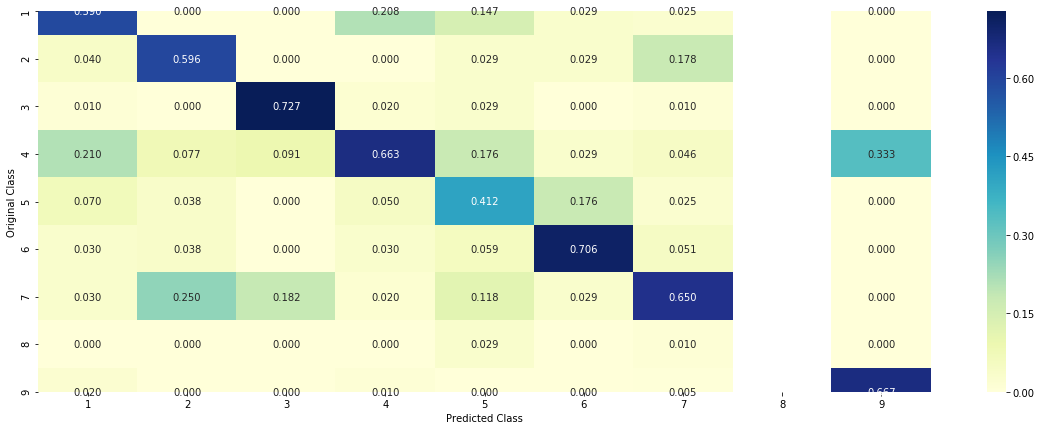

-------------------- Recall matrix (Row sum=1) --------------------


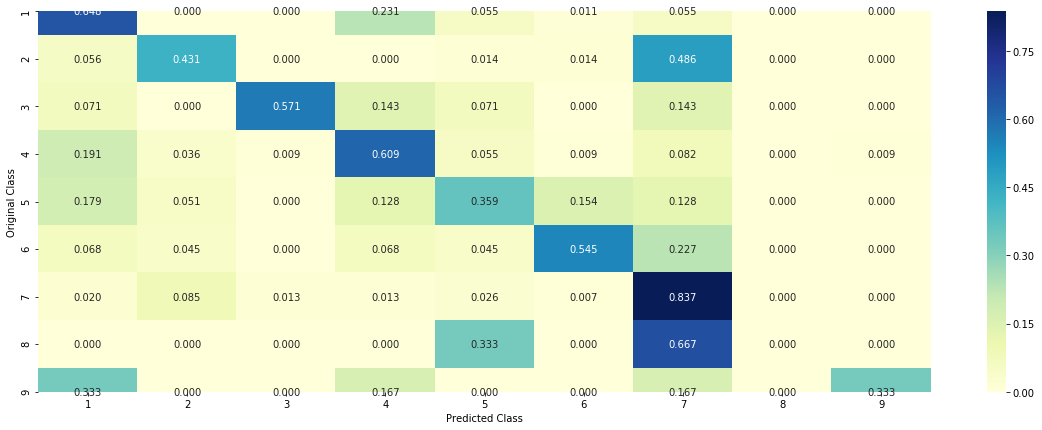

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 53342
for alpha = 1e-06
Log Loss : 1.3335428021454216
for alpha = 1e-05
Log Loss : 1.2940912357644196
for alpha = 0.0001
Log Loss : 1.1169384861263683
for alpha = 0.001
Log Loss : 1.0742785188411728
for alpha = 0.01
Log Loss : 1.1257668239837402
for alpha = 0.1
Log Loss : 1.309164677162756
for alpha = 1
Log Loss : 1.5532101290629372
for alpha = 10
Log Loss : 1.5931591735090929
for alpha = 100
Log Loss : 1.5975081038731727


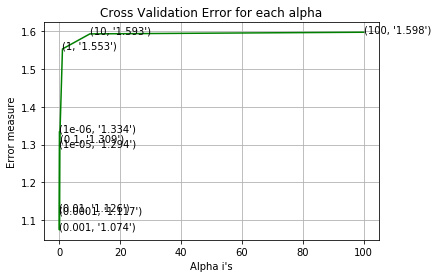

For values of best alpha =  0.001 The train log loss is: 0.5894138372791824
For values of best alpha =  0.001 The cross validation log loss is: 1.0742785188411728
For values of best alpha =  0.001 The test log loss is: 1.109269930742232
Log loss : 1.0742785188411728
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


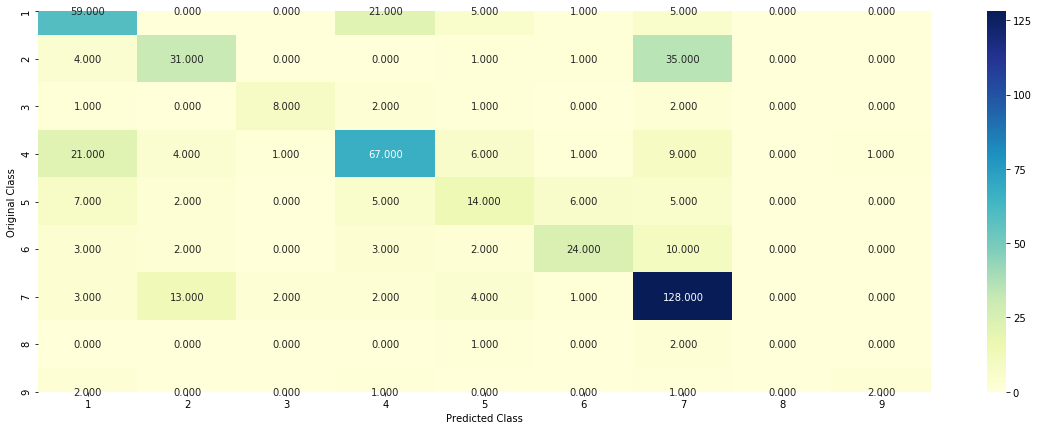

-------------------- Precision matrix (Columm Sum=1) --------------------


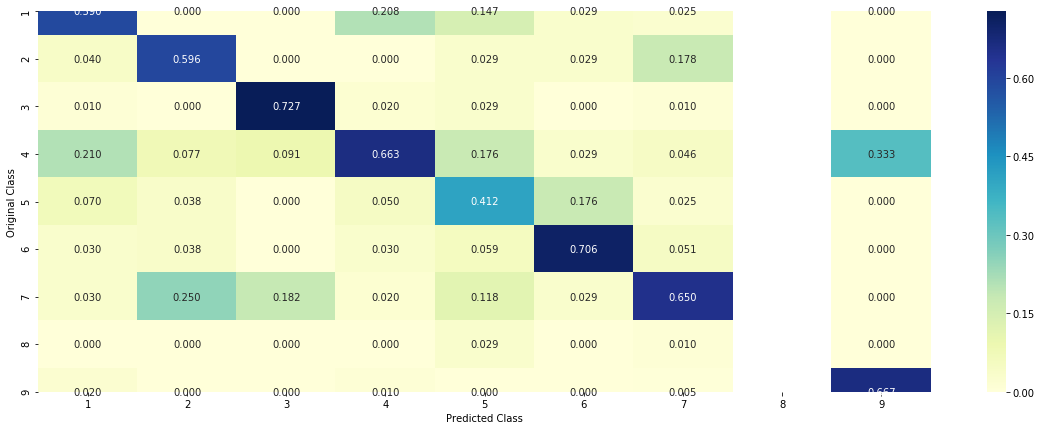

-------------------- Recall matrix (Row sum=1) --------------------


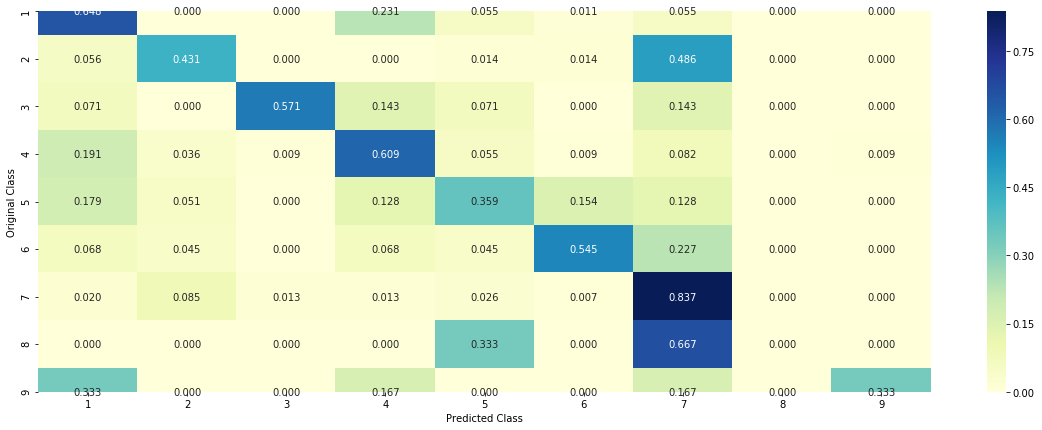

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(min_df=3)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 5000
for alpha = 1e-06
Log Loss : 1.1649103616123597
for alpha = 1e-05
Log Loss : 1.1116292127089509
for alpha = 0.0001
Log Loss : 1.134415797273636
for alpha = 0.001
Log Loss : 1.1845677632859941
for alpha = 0.01
Log Loss : 1.3005759814391387
for alpha = 0.1
Log Loss : 1.816333339774536
for alpha = 1
Log Loss : 1.8648232632169583
for alpha = 10
Log Loss : 1.869025179148348
for alpha = 100
Log Loss : 1.8695263075006114


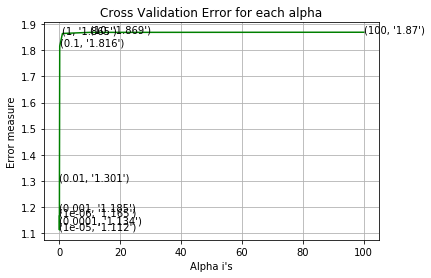

For values of best alpha =  1e-05 The train log loss is: 0.46673250266959065
For values of best alpha =  1e-05 The cross validation log loss is: 1.1116292127089509
For values of best alpha =  1e-05 The test log loss is: 1.0645546452850565
Log loss : 1.1116292127089509
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


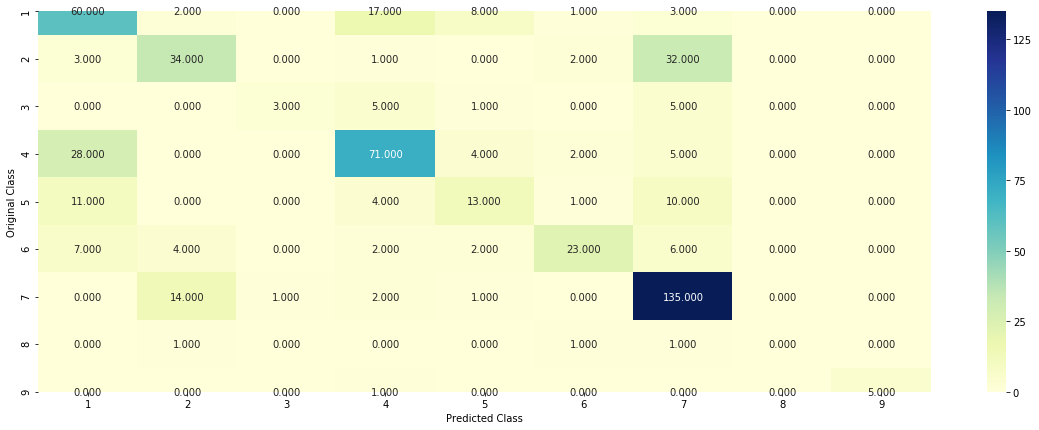

-------------------- Precision matrix (Columm Sum=1) --------------------


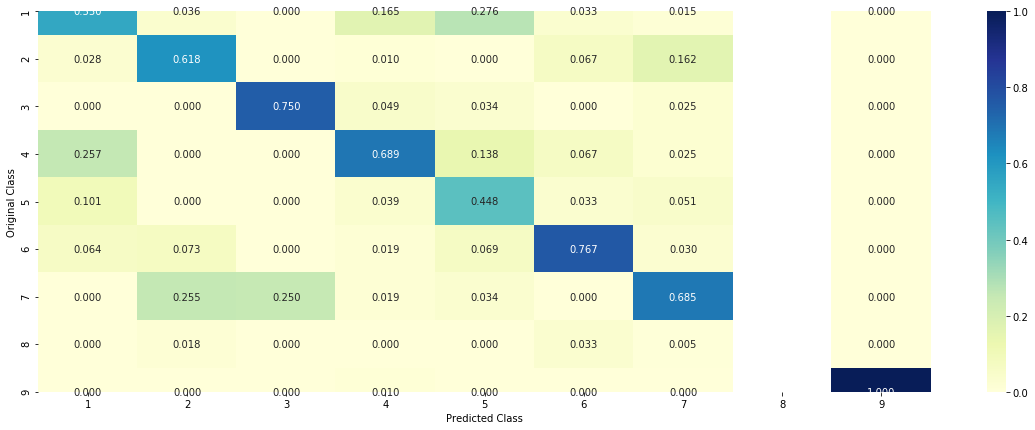

-------------------- Recall matrix (Row sum=1) --------------------


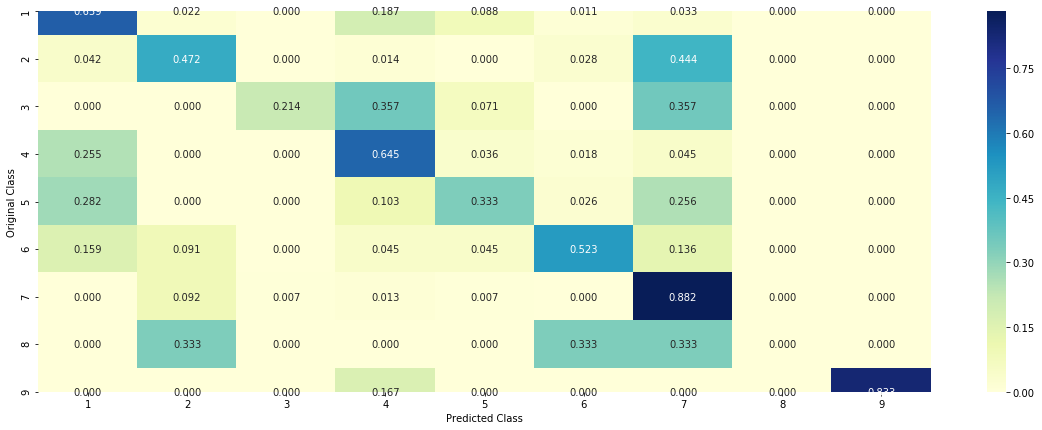

In [ ]:

gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(max_features=5000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 2000
for alpha = 1e-06
Log Loss : 1.1560016833133422
for alpha = 1e-05
Log Loss : 1.1438689179604251
for alpha = 0.0001
Log Loss : 1.1287264817704084
for alpha = 0.001
Log Loss : 1.3580026506789205
for alpha = 0.01
Log Loss : 1.8299418622219366
for alpha = 0.1
Log Loss : 1.8302599806950142
for alpha = 1
Log Loss : 1.8302599806230153
for alpha = 10
Log Loss : 1.8302599806220328
for alpha = 100
Log Loss : 1.8302599806220097


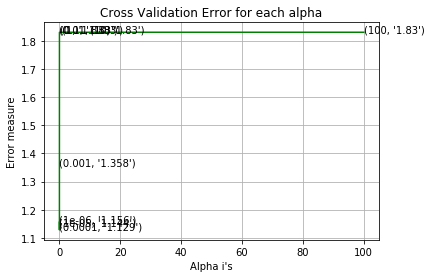

For values of best alpha =  0.0001 The train log loss is: 0.5010375537760908
For values of best alpha =  0.0001 The cross validation log loss is: 1.1287264817704084
For values of best alpha =  0.0001 The test log loss is: 1.0753423939271902
Log loss : 1.1287264817704084
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


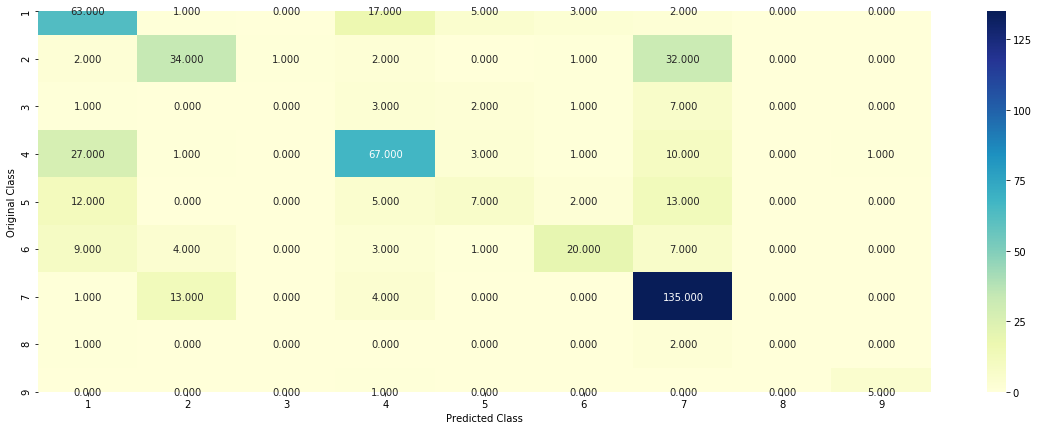

-------------------- Precision matrix (Columm Sum=1) --------------------


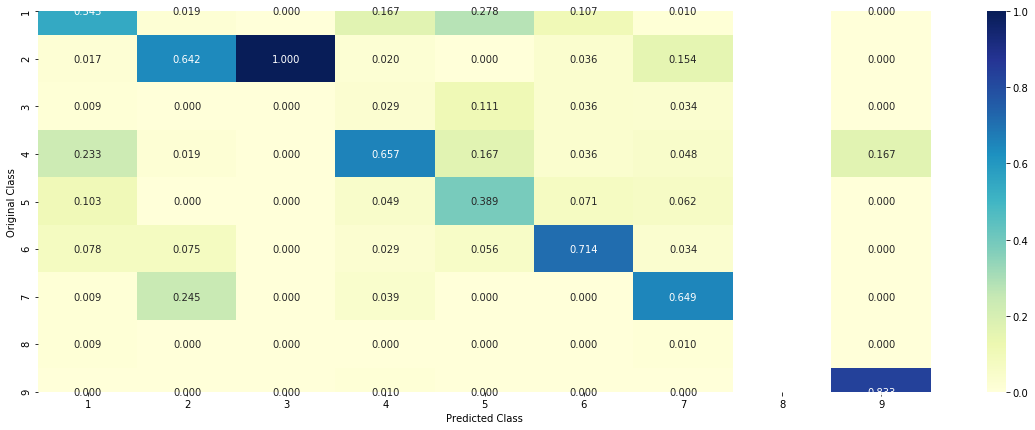

-------------------- Recall matrix (Row sum=1) --------------------


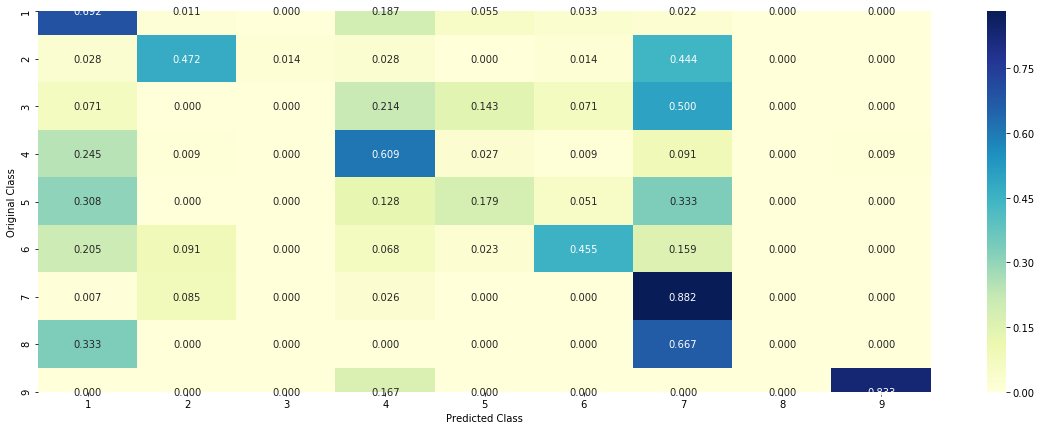

In [ ]:
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(max_features=2000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 2000
for alpha = 1e-06
Log Loss : 1.1560016833133422
for alpha = 1e-05
Log Loss : 1.1438689179604251
for alpha = 0.0001
Log Loss : 1.1287264817704084
for alpha = 0.001
Log Loss : 1.3580026506789205
for alpha = 0.01
Log Loss : 1.8299418622219366
for alpha = 0.1
Log Loss : 1.8302599806950142
for alpha = 1
Log Loss : 1.8302599806230153
for alpha = 10
Log Loss : 1.8302599806220328
for alpha = 100
Log Loss : 1.8302599806220097


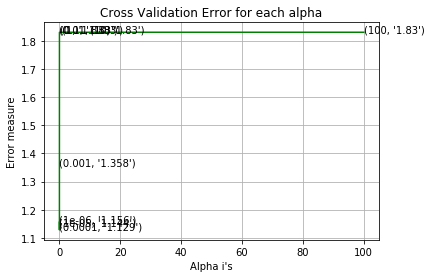

For values of best alpha =  0.0001 The train log loss is: 0.5010375537760908
For values of best alpha =  0.0001 The cross validation log loss is: 1.1287264817704084
For values of best alpha =  0.0001 The test log loss is: 1.0753423939271902
Log loss : 1.1287264817704084
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


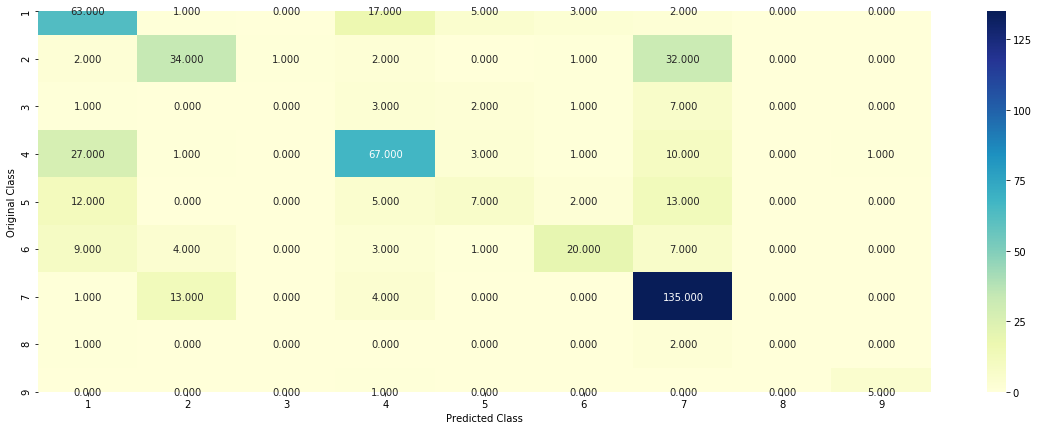

-------------------- Precision matrix (Columm Sum=1) --------------------


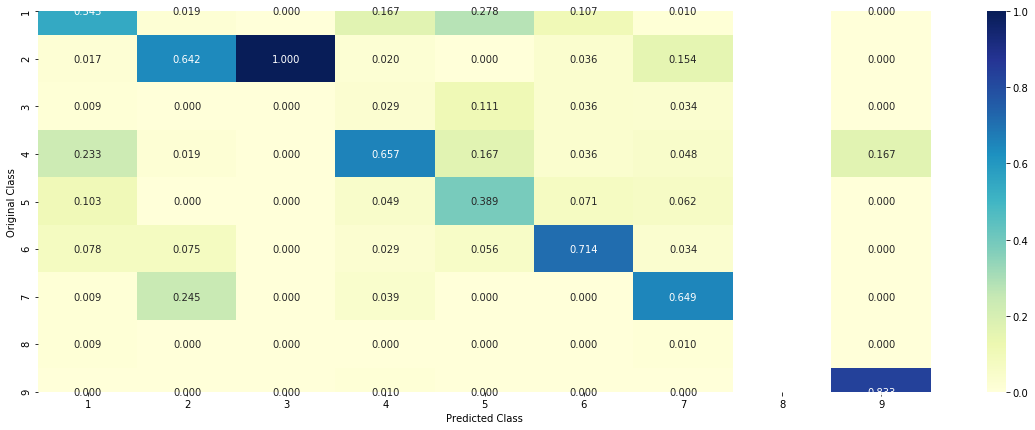

-------------------- Recall matrix (Row sum=1) --------------------


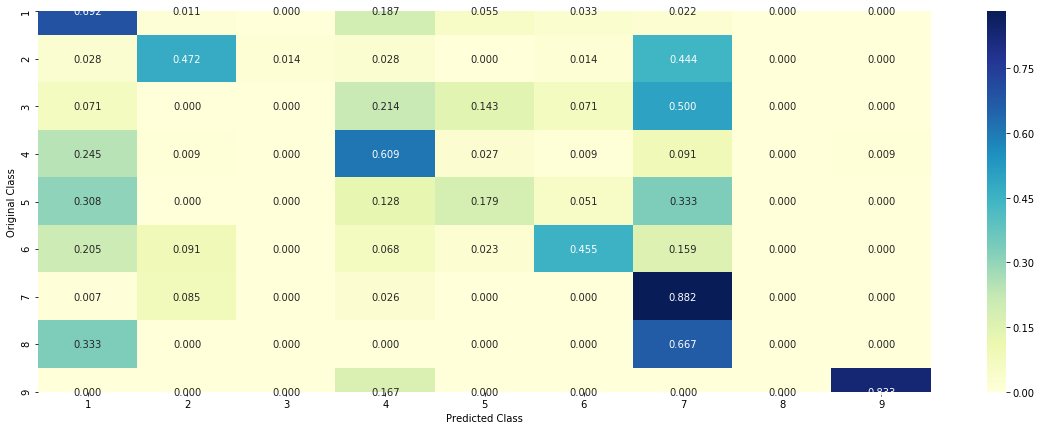

In [ ]:
#l1
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(max_features=2000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 2000
for alpha = 1e-06
Log Loss : 1.233675415074538
for alpha = 1e-05
Log Loss : 1.1094711261068158
for alpha = 0.0001
Log Loss : 1.0810207912627945
for alpha = 0.001
Log Loss : 1.1416507172979564
for alpha = 0.01
Log Loss : 1.3290694223729858
for alpha = 0.1
Log Loss : 1.5360714230525576
for alpha = 1
Log Loss : 1.5942796124546443
for alpha = 10
Log Loss : 1.600633515007101
for alpha = 100
Log Loss : 1.6013322341503244


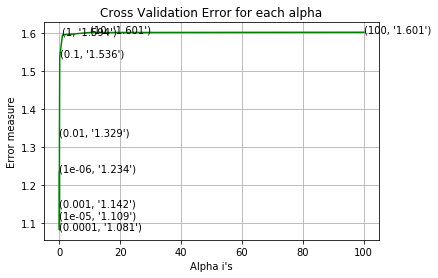

For values of best alpha =  0.0001 The train log loss is: 0.44561041683631497
For values of best alpha =  0.0001 The cross validation log loss is: 1.0810207912627945
For values of best alpha =  0.0001 The test log loss is: 1.0525429891069387
Log loss : 1.0810207912627945
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


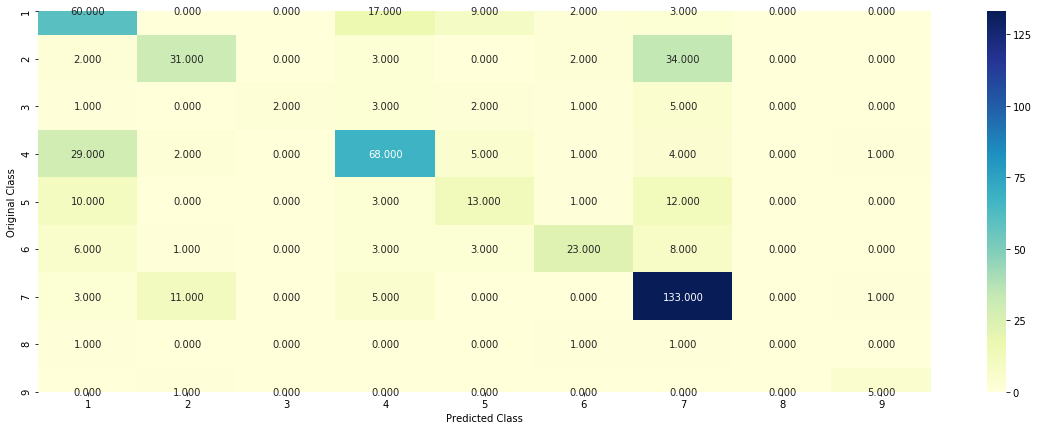

-------------------- Precision matrix (Columm Sum=1) --------------------


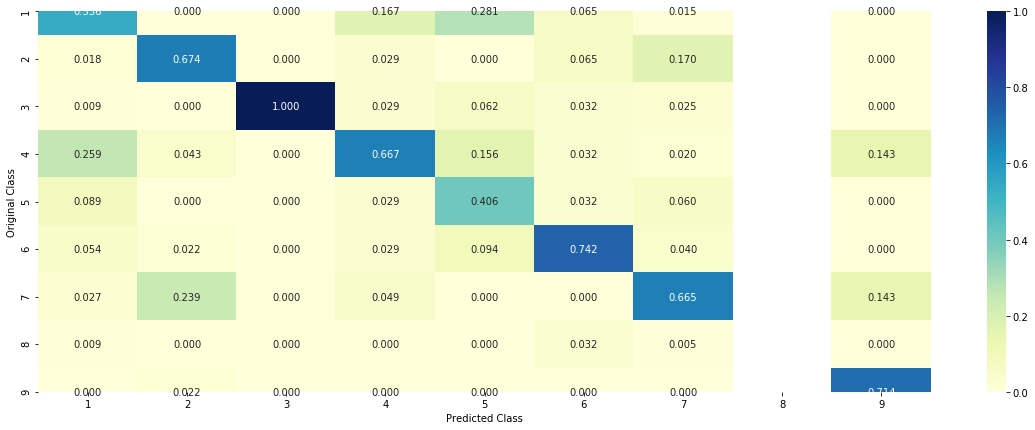

-------------------- Recall matrix (Row sum=1) --------------------


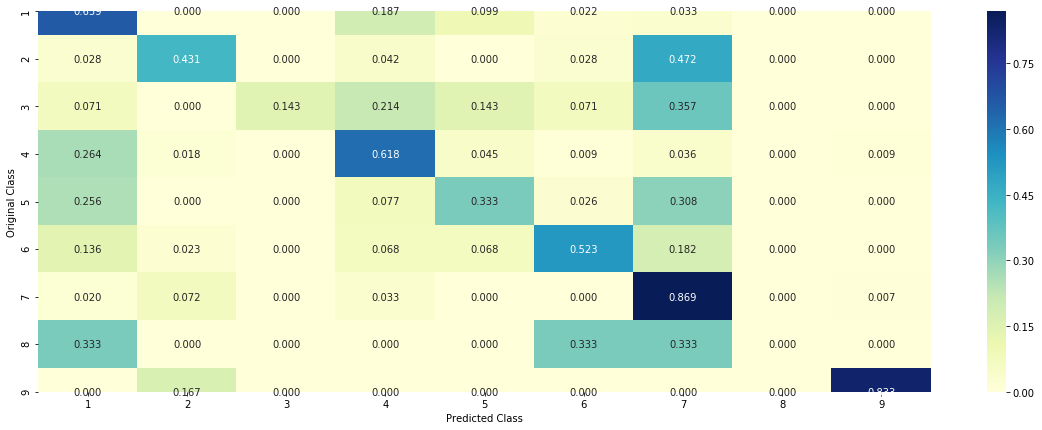

In [ ]:
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=2000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 1000
for alpha = 1e-06
Log Loss : 1.2298612352250875
for alpha = 1e-05
Log Loss : 1.1198374644359383
for alpha = 0.0001
Log Loss : 1.0873705673799983
for alpha = 0.001
Log Loss : 1.15716202832267
for alpha = 0.01
Log Loss : 1.3290609516856846
for alpha = 0.1
Log Loss : 1.551107443035602
for alpha = 1
Log Loss : 1.6188464011842074
for alpha = 10
Log Loss : 1.6267002937238955
for alpha = 100
Log Loss : 1.6275789265136358


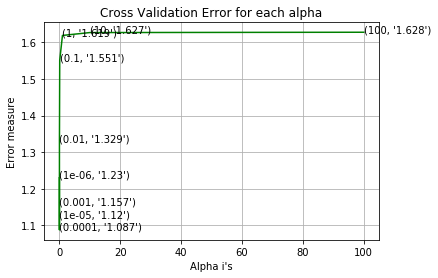

For values of best alpha =  0.0001 The train log loss is: 0.4425637743871744
For values of best alpha =  0.0001 The cross validation log loss is: 1.0873705673799983
For values of best alpha =  0.0001 The test log loss is: 1.0647705772954081
Log loss : 1.0873705673799983
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


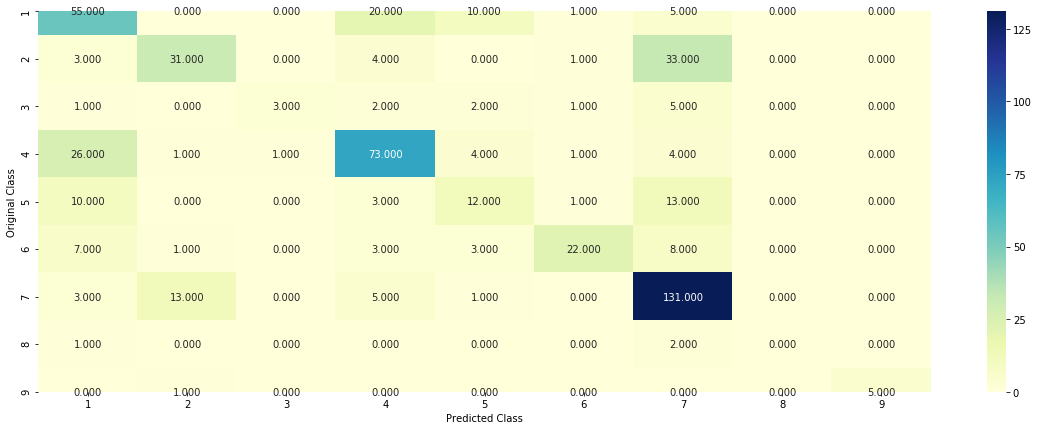

-------------------- Precision matrix (Columm Sum=1) --------------------


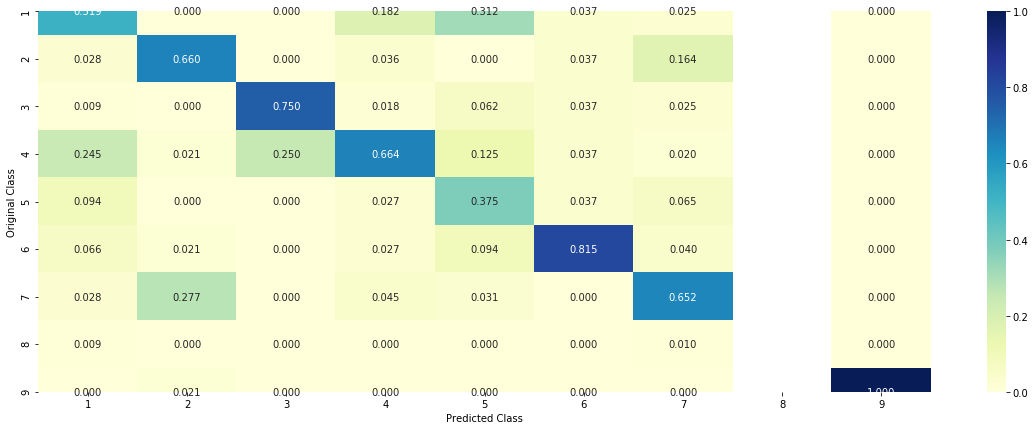

-------------------- Recall matrix (Row sum=1) --------------------


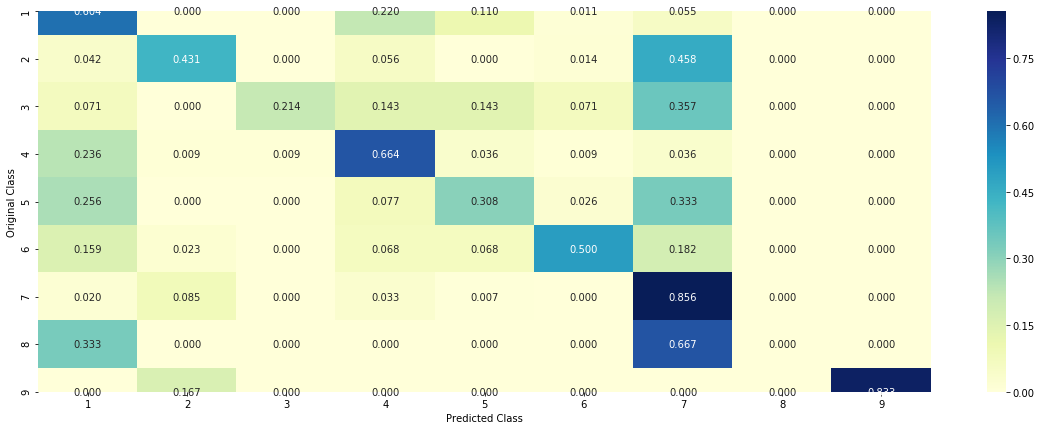

In [ ]:
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=1000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 5000
for alpha = 1e-06
Log Loss : 1.3534932289888812
for alpha = 1e-05
Log Loss : 1.1776241658430986
for alpha = 0.0001
Log Loss : 1.109203058119124
for alpha = 0.001
Log Loss : 1.1393863552673749
for alpha = 0.01
Log Loss : 1.3917895833965817
for alpha = 0.1
Log Loss : 1.7151317049495889
for alpha = 1
Log Loss : 1.701941440674416
for alpha = 10
Log Loss : 1.7036606173971232
for alpha = 100
Log Loss : 1.7066477409629828


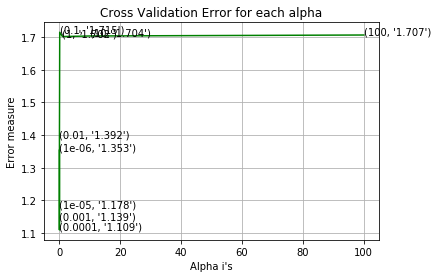

For values of best alpha =  0.0001 The train log loss is: 0.47680642342513774
For values of best alpha =  0.0001 The cross validation log loss is: 1.109203058119124
For values of best alpha =  0.0001 The test log loss is: 1.0535357260652587
Log loss : 1.109203058119124
Number of mis-classified points : 0.3815789473684211
-------------------- Confusion matrix --------------------


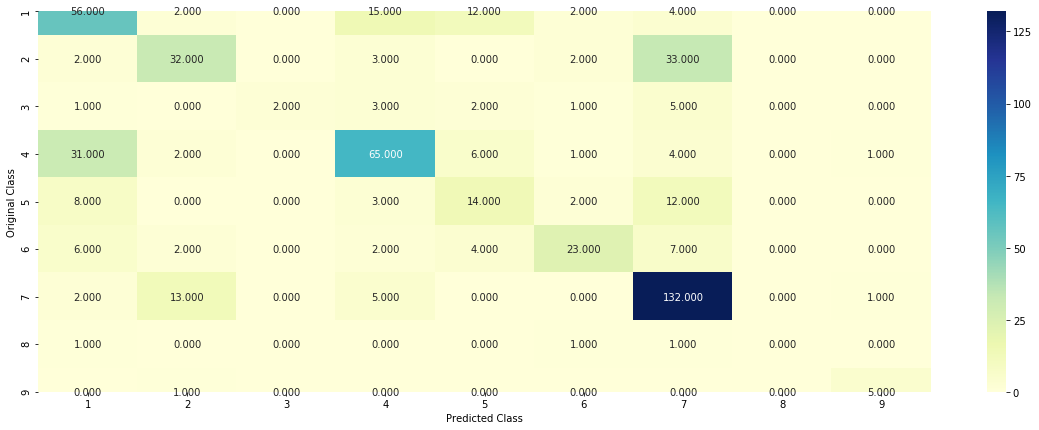

-------------------- Precision matrix (Columm Sum=1) --------------------


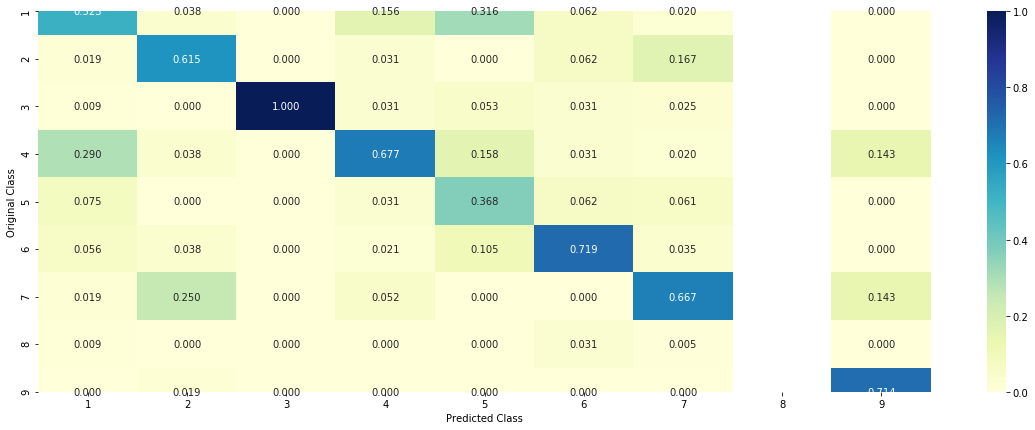

-------------------- Recall matrix (Row sum=1) --------------------


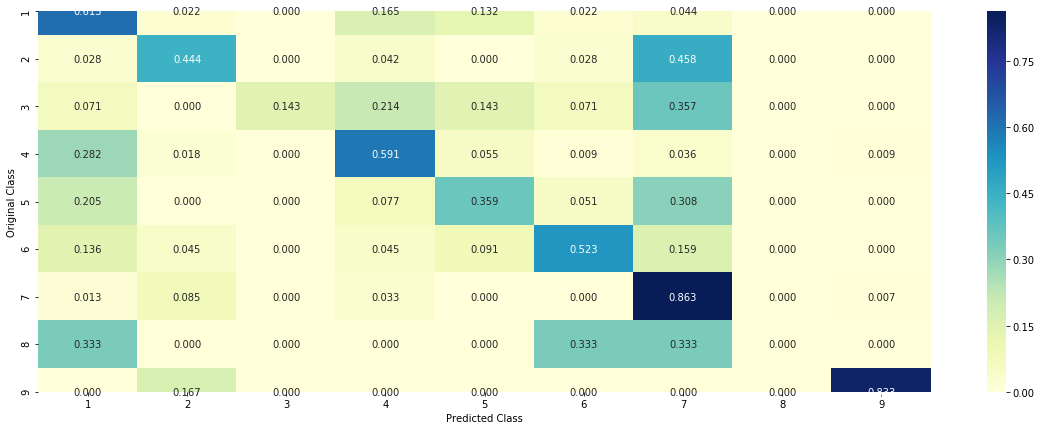

In [ ]:
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=5000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 10000
for alpha = 1e-06
Log Loss : 1.3927778020244665
for alpha = 1e-05
Log Loss : 1.248300376523382
for alpha = 0.0001
Log Loss : 1.0971977407974352
for alpha = 0.001
Log Loss : 1.1402363092741
for alpha = 0.01
Log Loss : 1.3674732295290928
for alpha = 0.1
Log Loss : 1.631272135270039
for alpha = 1
Log Loss : 1.7165211110888339
for alpha = 10
Log Loss : 1.7259008773195588
for alpha = 100
Log Loss : 1.7266225733609681


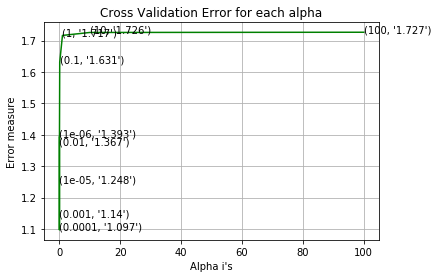

For values of best alpha =  0.0001 The train log loss is: 0.5390588630855644
For values of best alpha =  0.0001 The cross validation log loss is: 1.0971977407974352
For values of best alpha =  0.0001 The test log loss is: 1.095165630664126
Log loss : 1.0971977407974352
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


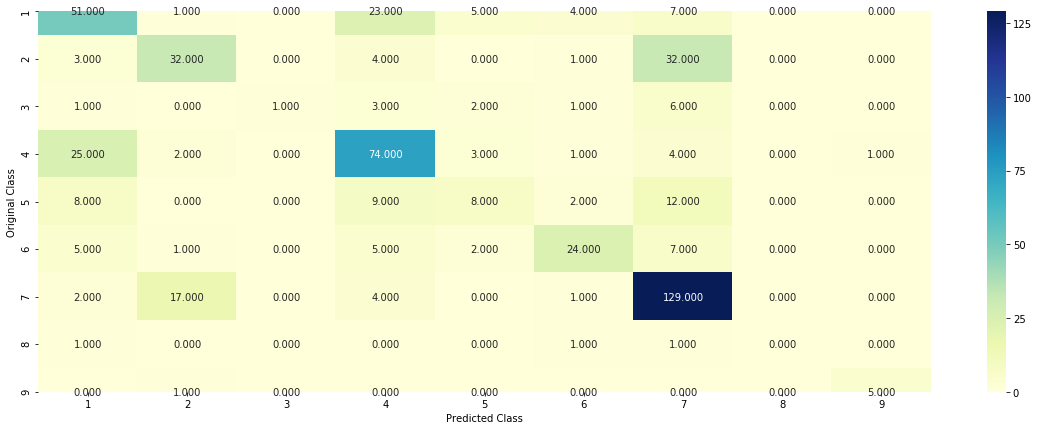

-------------------- Precision matrix (Columm Sum=1) --------------------


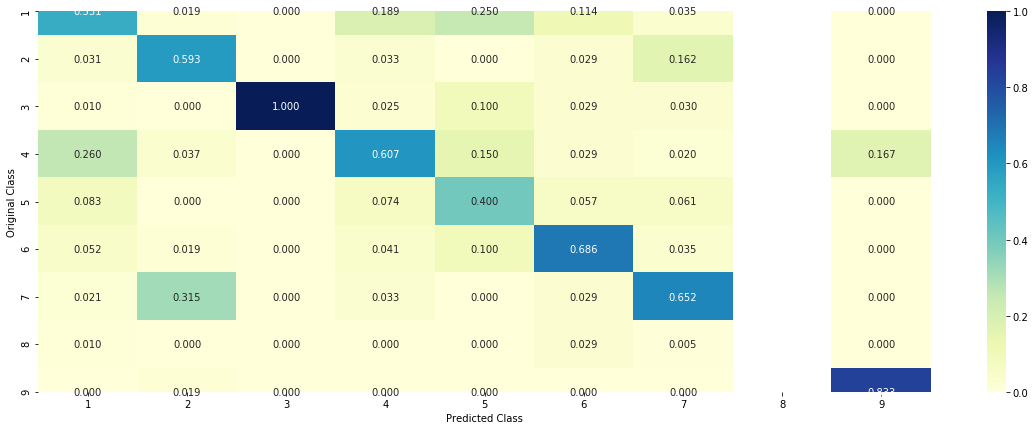

-------------------- Recall matrix (Row sum=1) --------------------


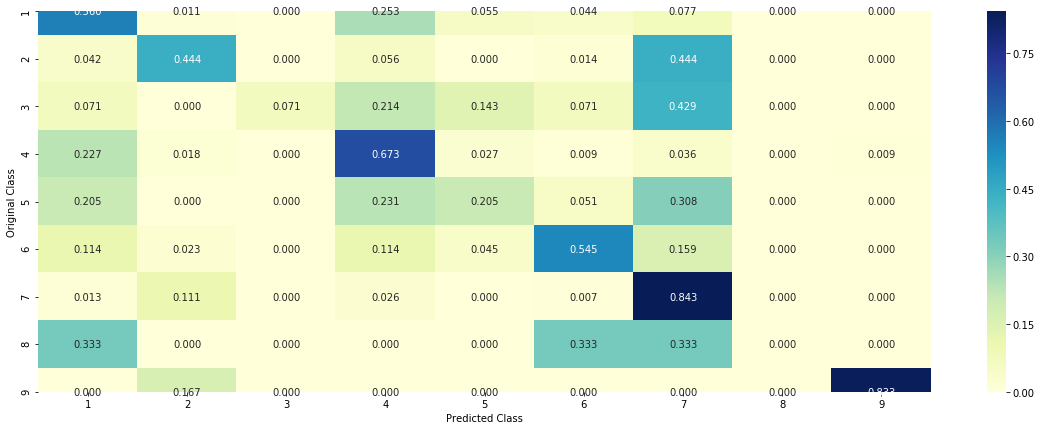

In [ ]:
gene_vectorizer = CountVectorizer()
variation_vectorizer =CountVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=10000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 2000
for alpha = 1e-06
Log Loss : 1.2283360974360946
for alpha = 1e-05
Log Loss : 1.108599337292209
for alpha = 0.0001
Log Loss : 1.081034305893885
for alpha = 0.001
Log Loss : 1.141727513746654
for alpha = 0.01
Log Loss : 1.329117198644112
for alpha = 0.1
Log Loss : 1.5360785070557412
for alpha = 1
Log Loss : 1.5942846149255698
for alpha = 10
Log Loss : 1.6006383434383638
for alpha = 100
Log Loss : 1.6013370442519466


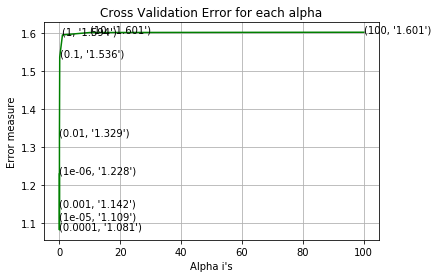

For values of best alpha =  0.0001 The train log loss is: 0.44557678511958243
For values of best alpha =  0.0001 The cross validation log loss is: 1.081034305893885
For values of best alpha =  0.0001 The test log loss is: 1.052586454129698
Log loss : 1.081034305893885
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


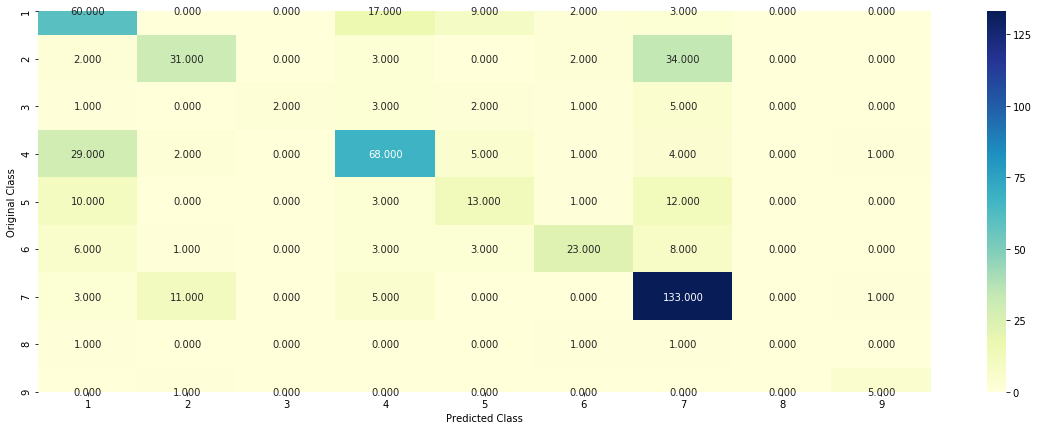

-------------------- Precision matrix (Columm Sum=1) --------------------


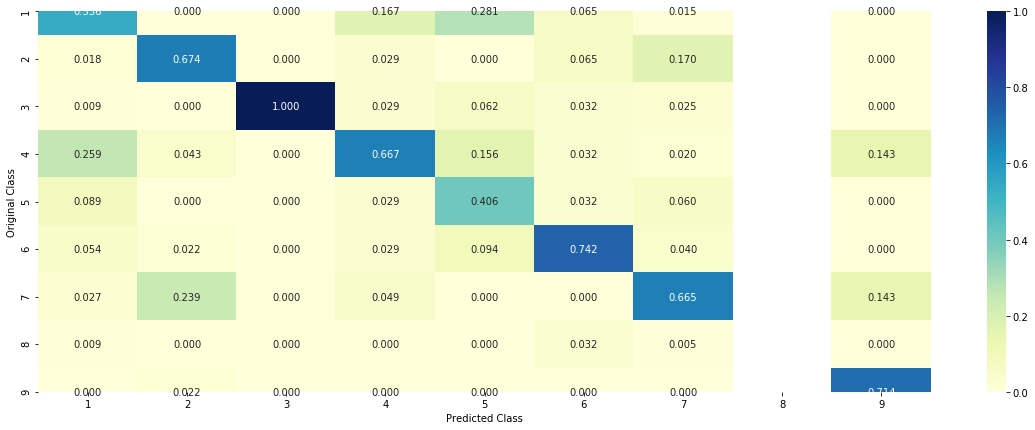

-------------------- Recall matrix (Row sum=1) --------------------


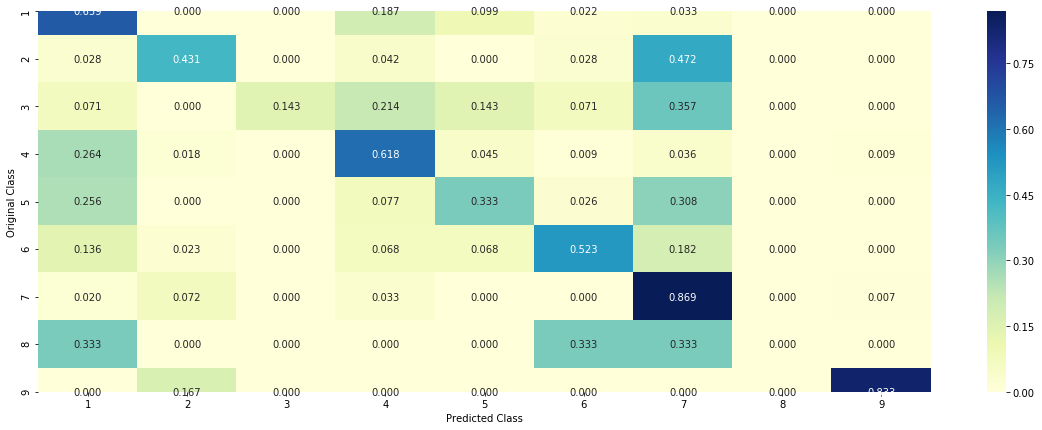

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=2000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 1000
for alpha = 1e-06
Log Loss : 1.232304446230201
for alpha = 1e-05
Log Loss : 1.1195476505856543
for alpha = 0.0001
Log Loss : 1.0873506843649958
for alpha = 0.001
Log Loss : 1.1572424573402267
for alpha = 0.01
Log Loss : 1.329112258848168
for alpha = 0.1
Log Loss : 1.5511123307748529
for alpha = 1
Log Loss : 1.6188509353462528
for alpha = 10
Log Loss : 1.626704878032697
for alpha = 100
Log Loss : 1.6275835207047453


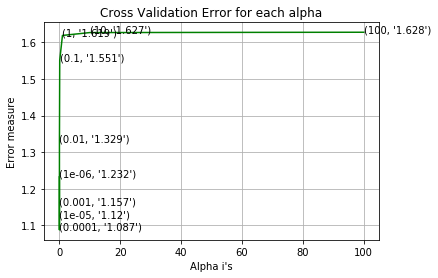

For values of best alpha =  0.0001 The train log loss is: 0.44253121639488086
For values of best alpha =  0.0001 The cross validation log loss is: 1.0873506843649958
For values of best alpha =  0.0001 The test log loss is: 1.0646478435865396
Log loss : 1.0873506843649958
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


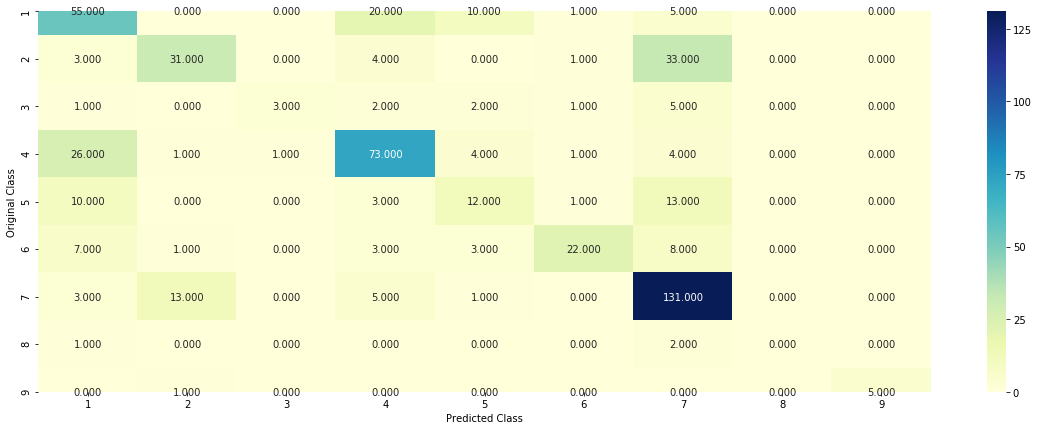

-------------------- Precision matrix (Columm Sum=1) --------------------


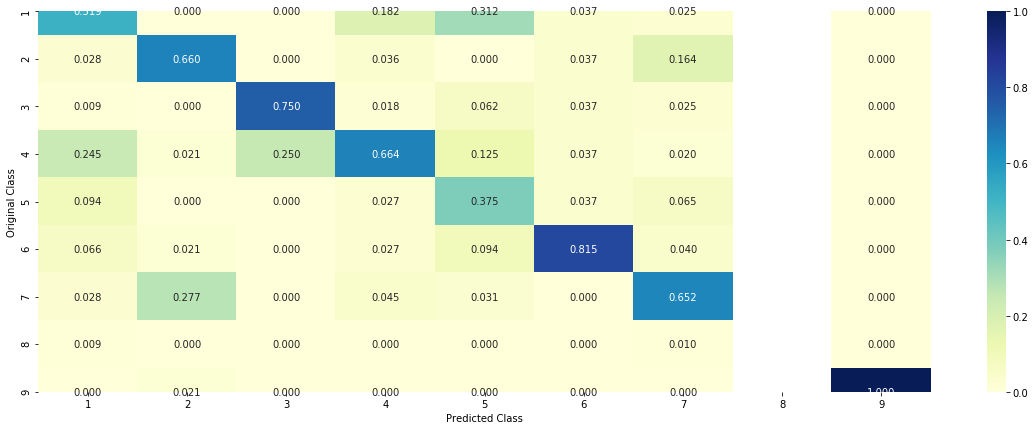

-------------------- Recall matrix (Row sum=1) --------------------


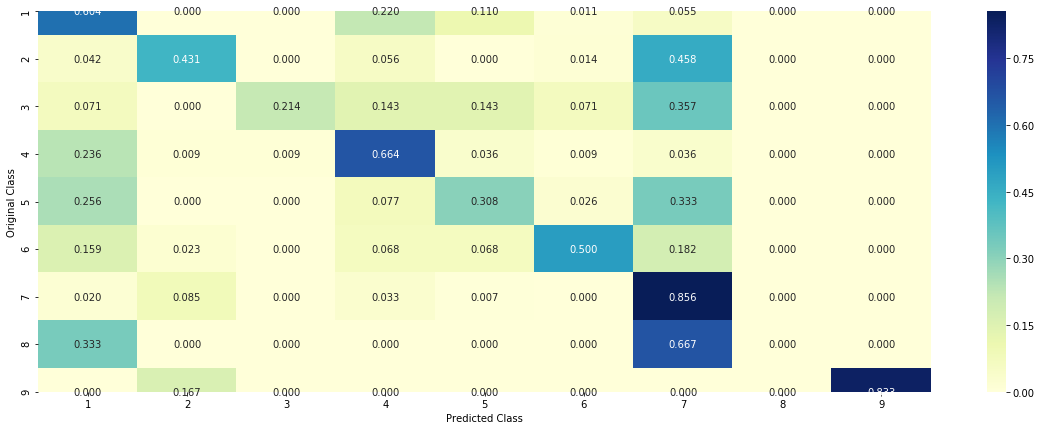

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=1000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Total number of unique words in train data : 5000
for alpha = 1e-06
Log Loss : 1.357125603667165
for alpha = 1e-05
Log Loss : 1.121966572301001
for alpha = 0.0001
Log Loss : 1.105722226078421
for alpha = 0.001
Log Loss : 1.1394503744978763
for alpha = 0.01
Log Loss : 1.3918300580470568
for alpha = 0.1
Log Loss : 1.7151393572923102
for alpha = 1
Log Loss : 1.70194425272303
for alpha = 10
Log Loss : 1.7036627195732643
for alpha = 100
Log Loss : 1.7066497001823364


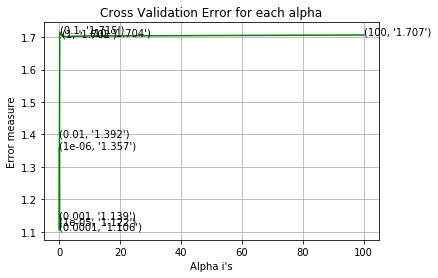

For values of best alpha =  0.0001 The train log loss is: 0.48949438089256403
For values of best alpha =  0.0001 The cross validation log loss is: 1.105722226078421
For values of best alpha =  0.0001 The test log loss is: 1.0579662951548365
Log loss : 1.105722226078421
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


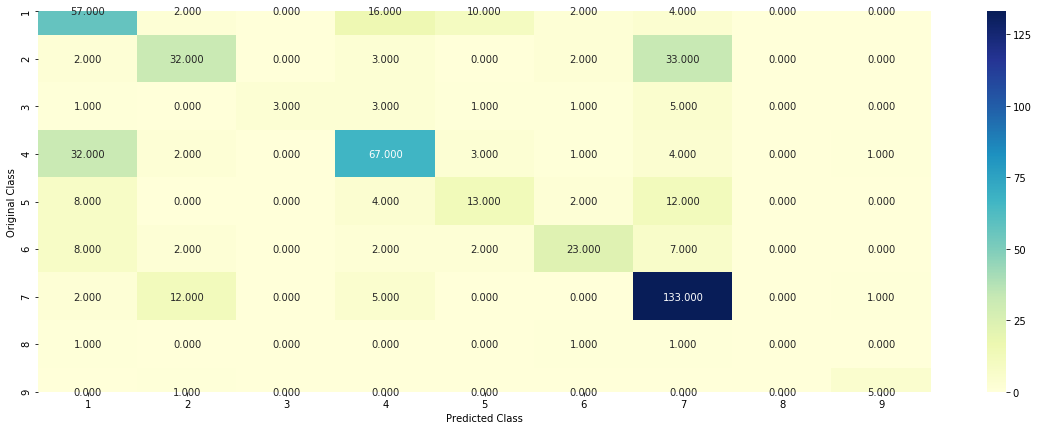

-------------------- Precision matrix (Columm Sum=1) --------------------


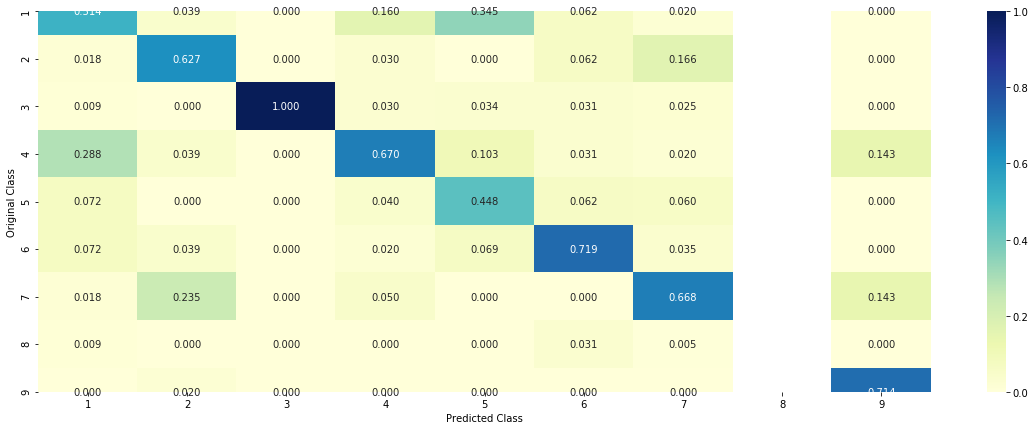

-------------------- Recall matrix (Row sum=1) --------------------


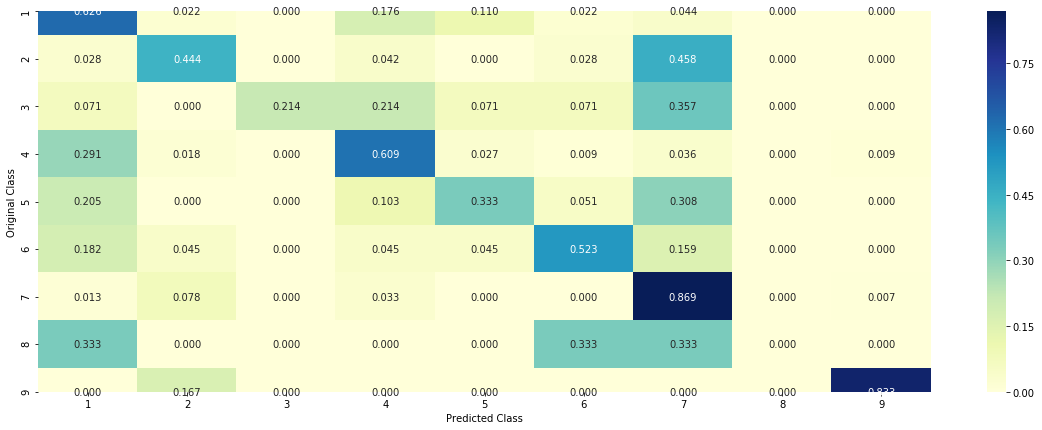

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=5000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize(gene_vectorizer, variation_vectorizer, text_vectorizer)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

In [ ]:
def vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer, BestK):
    from sklearn.feature_selection import SelectKBest
       
    train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
    test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
    cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

    # one-hot encoding of variation feature.
    
    train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
    test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
    cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

    # building a CountVectorizer with all the words that occured minimum 3 times in train data
    score = SelectKBest(k=BestK)
    
    train_text_feature_onehotCoding_ = text_vectorizer.fit_transform(X_train['TEXT'])
    print ("Shape after max features = ",train_text_feature_onehotCoding_.shape)
    train_text_feature_onehotCoding = score.fit_transform(train_text_feature_onehotCoding_, y_train)
    print ("Shape after max score = ",train_text_feature_onehotCoding.shape)

    # don't forget to normalize every feature
    train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

    # getting all the feature names (words)
    train_text_features= text_vectorizer.get_feature_names()

    # train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
    train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

    # zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
    text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


    print("Total number of unique words in train data :", len(train_text_features))

    # we use the same vectorizer that was trained on train data
    test_text_feature_onehotCoding_ = text_vectorizer.transform(X_test['TEXT'])
    test_text_feature_onehotCoding = score.transform(test_text_feature_onehotCoding_)
    # don't forget to normalize every feature
    test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

    # we use the same vectorizer that was trained on train data
    cv_text_feature_onehotCoding_ = text_vectorizer.transform(X_cv['TEXT'])
    cv_text_feature_onehotCoding = score.transform(cv_text_feature_onehotCoding_)
    # don't forget to normalize every feature
    cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

    #normalize gene and variation


    
    train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
    test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
    cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

    train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
    test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
    cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
    
    return train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding

Shape after max features =  (2124, 10000)
Shape after max score =  (2124, 1000)
Total number of unique words in train data : 10000
for alpha = 1e-06
Log Loss : 1.2359170070637597
for alpha = 1e-05
Log Loss : 1.1219197417427316
for alpha = 0.0001
Log Loss : 1.0964385001843835
for alpha = 0.001
Log Loss : 1.1408510843195225
for alpha = 0.01
Log Loss : 1.3685286319127306
for alpha = 0.1
Log Loss : 1.483711408280347
for alpha = 1
Log Loss : 1.5493045676152208
for alpha = 10
Log Loss : 1.5618710232967816
for alpha = 100
Log Loss : 1.5624395102894226


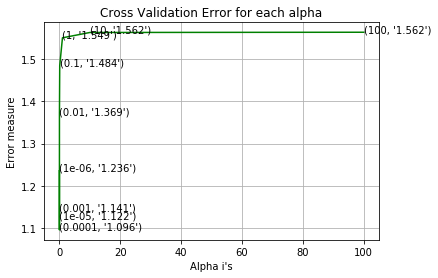

For values of best alpha =  0.0001 The train log loss is: 0.4035791986554126
For values of best alpha =  0.0001 The cross validation log loss is: 1.0964385001843835
For values of best alpha =  0.0001 The test log loss is: 1.0886690690539775
Log loss : 1.0964385001843835
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


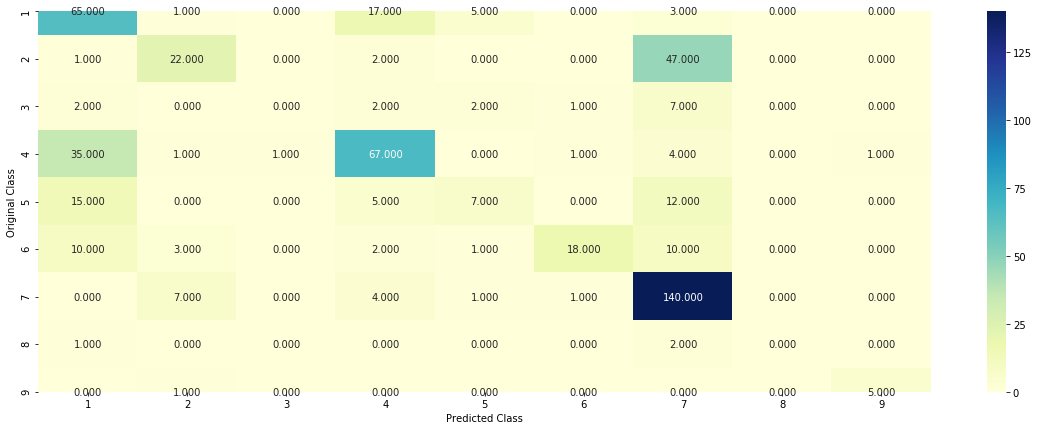

-------------------- Precision matrix (Columm Sum=1) --------------------


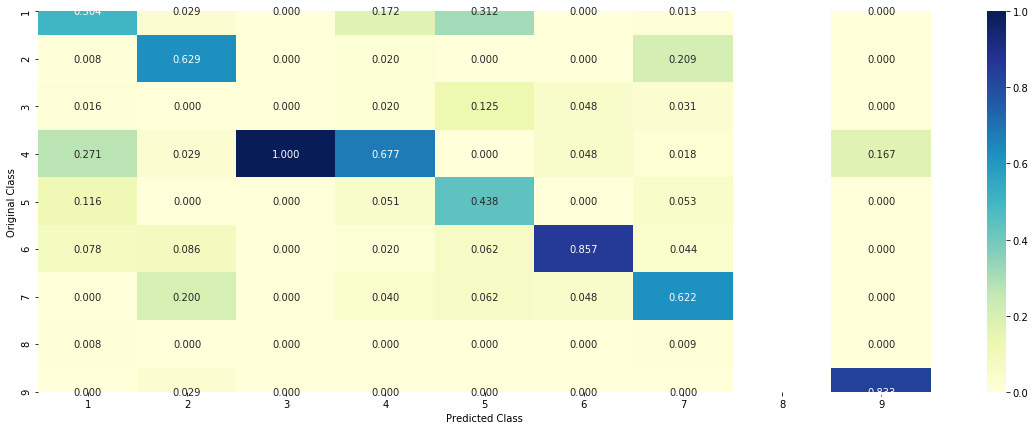

-------------------- Recall matrix (Row sum=1) --------------------


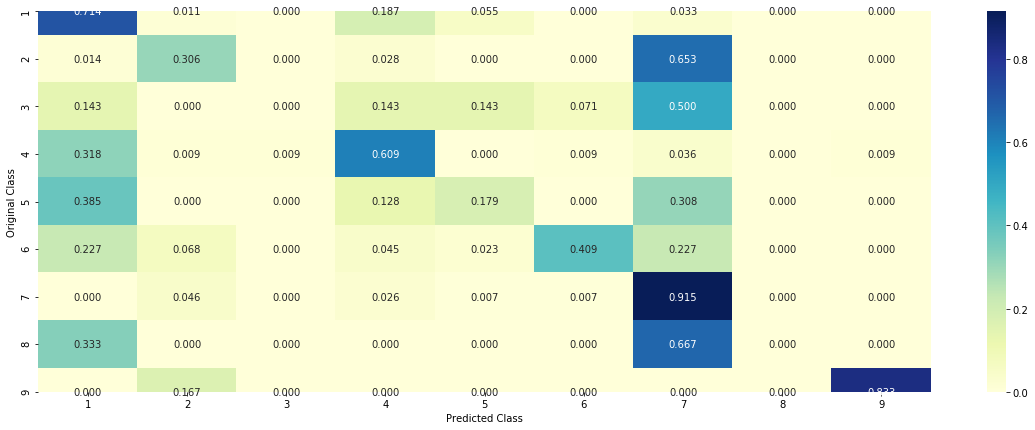

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4),max_features=10000)

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer,1000)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Shape after max features =  (2124, 5330394)
Shape after max score =  (2124, 1000)
Total number of unique words in train data : 5330394
for alpha = 1e-06
Log Loss : 1.345394693802779
for alpha = 1e-05
Log Loss : 1.1461790292101433
for alpha = 0.0001
Log Loss : 1.0826026807837936
for alpha = 0.001
Log Loss : 1.1219475823927645
for alpha = 0.01
Log Loss : 1.2265252812667884
for alpha = 0.1
Log Loss : 1.367239654245279
for alpha = 1
Log Loss : 1.4216435124591664
for alpha = 10
Log Loss : 1.4295695375991717
for alpha = 100
Log Loss : 1.4307140176975823


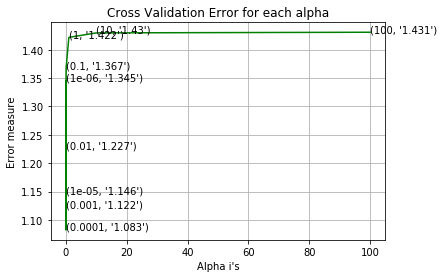

For values of best alpha =  0.0001 The train log loss is: 0.5290382526107023
For values of best alpha =  0.0001 The cross validation log loss is: 1.0826026807837936
For values of best alpha =  0.0001 The test log loss is: 1.0798970277740227
Log loss : 1.0826026807837936
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


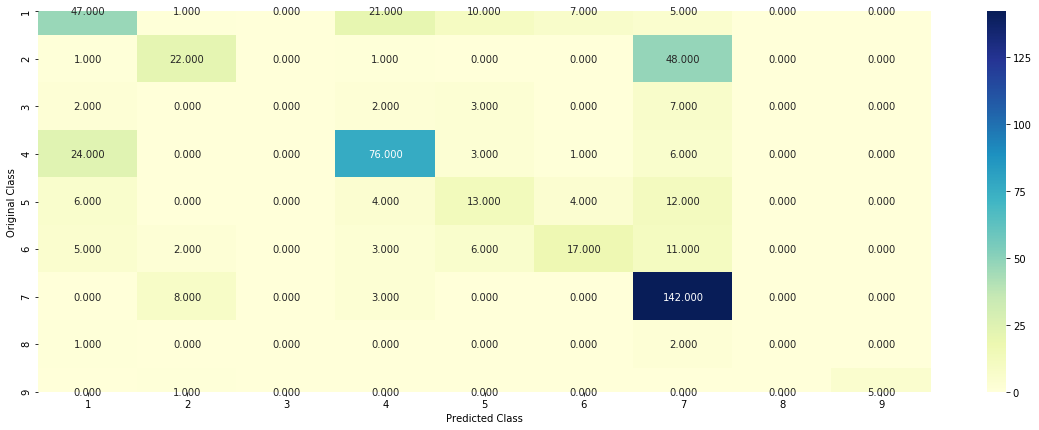

-------------------- Precision matrix (Columm Sum=1) --------------------


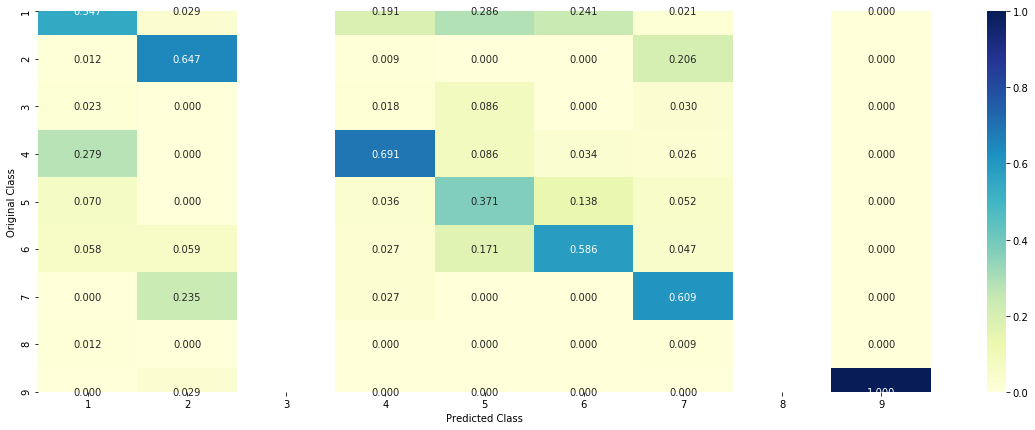

-------------------- Recall matrix (Row sum=1) --------------------


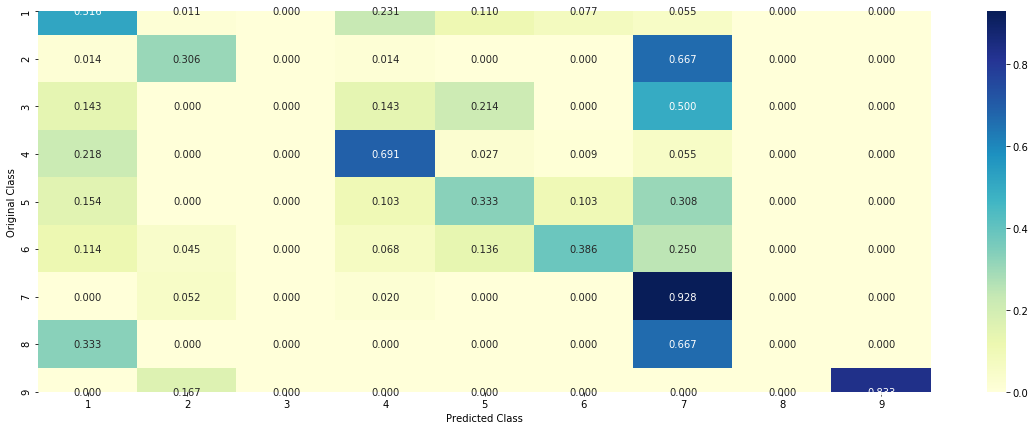

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4))

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer,1000)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Shape after max features =  (2124, 5330394)
Shape after max score =  (2124, 2000)
Total number of unique words in train data : 5330394
for alpha = 1e-06
Log Loss : 1.3460288507802527
for alpha = 1e-05
Log Loss : 1.1465290770981327
for alpha = 0.0001
Log Loss : 1.0854290927106707
for alpha = 0.001
Log Loss : 1.1220339975788325
for alpha = 0.01
Log Loss : 1.22673832617446
for alpha = 0.1
Log Loss : 1.3680273848968958
for alpha = 1
Log Loss : 1.4223992949997364
for alpha = 10
Log Loss : 1.4297856599829568
for alpha = 100
Log Loss : 1.4310632366366804


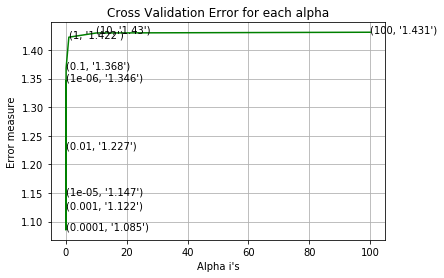

For values of best alpha =  0.0001 The train log loss is: 0.5317865963462043
For values of best alpha =  0.0001 The cross validation log loss is: 1.0854290927106707
For values of best alpha =  0.0001 The test log loss is: 1.0831231748343733
Log loss : 1.0854290927106707
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


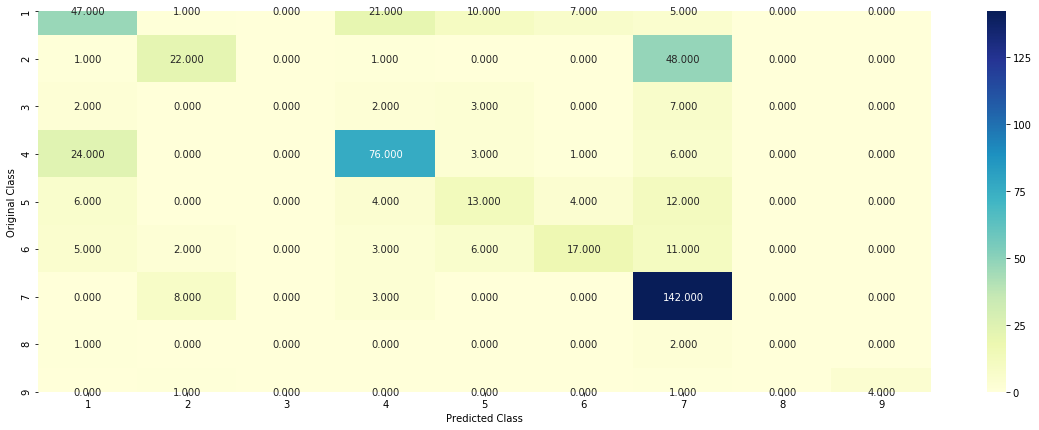

-------------------- Precision matrix (Columm Sum=1) --------------------


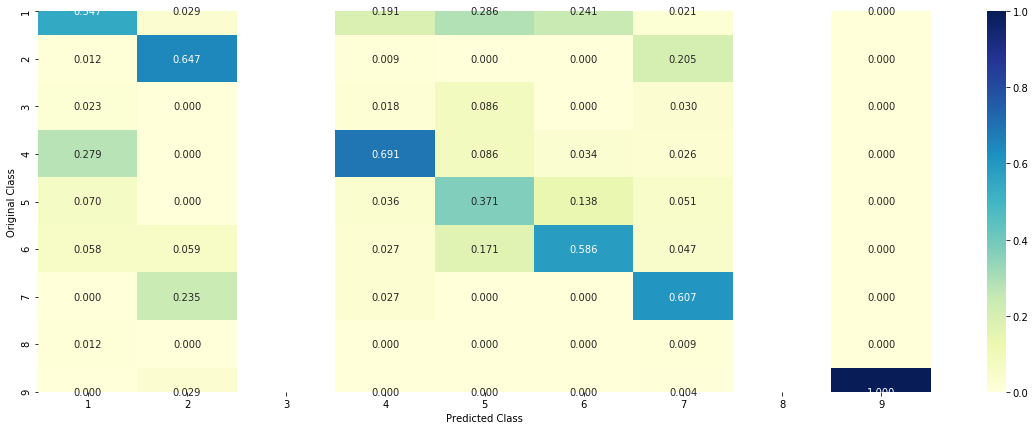

-------------------- Recall matrix (Row sum=1) --------------------


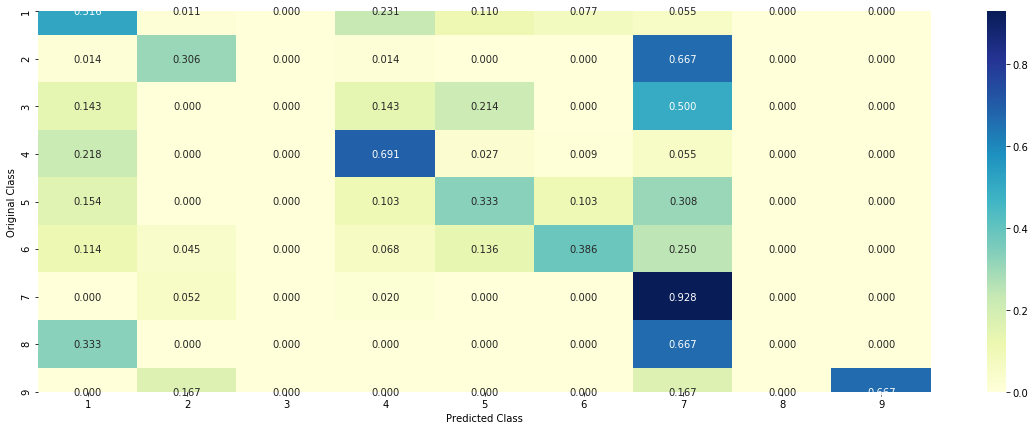

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4))

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer,2000)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Shape after max features =  (2124, 5330394)
Shape after max score =  (2124, 500)
Total number of unique words in train data : 5330394
for alpha = 1e-06
Log Loss : 1.345257762923051
for alpha = 1e-05
Log Loss : 1.1458377277158711
for alpha = 0.0001
Log Loss : 1.0821801672966411
for alpha = 0.001
Log Loss : 1.1218504813329209
for alpha = 0.01
Log Loss : 1.226295470774988
for alpha = 0.1
Log Loss : 1.3654591902490911
for alpha = 1
Log Loss : 1.418896598424581
for alpha = 10
Log Loss : 1.4271315214410607
for alpha = 100
Log Loss : 1.428433569346659


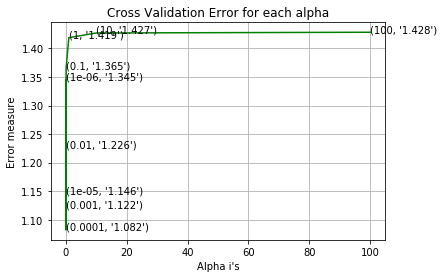

For values of best alpha =  0.0001 The train log loss is: 0.5286781445489003
For values of best alpha =  0.0001 The cross validation log loss is: 1.0821801672966411
For values of best alpha =  0.0001 The test log loss is: 1.079322372718718
Log loss : 1.0821801672966411
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


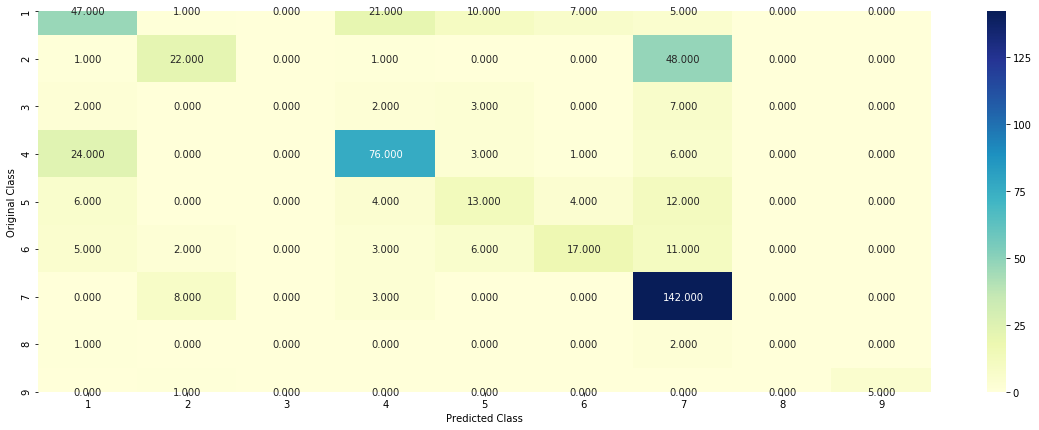

-------------------- Precision matrix (Columm Sum=1) --------------------


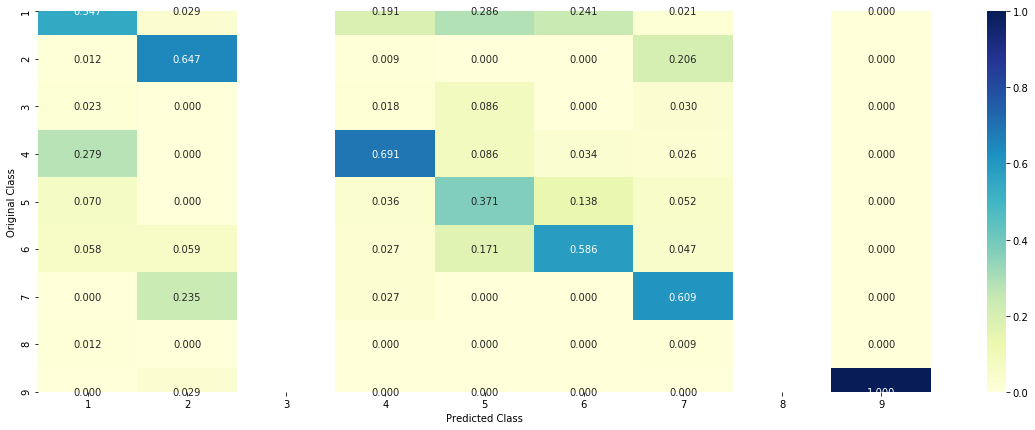

-------------------- Recall matrix (Row sum=1) --------------------


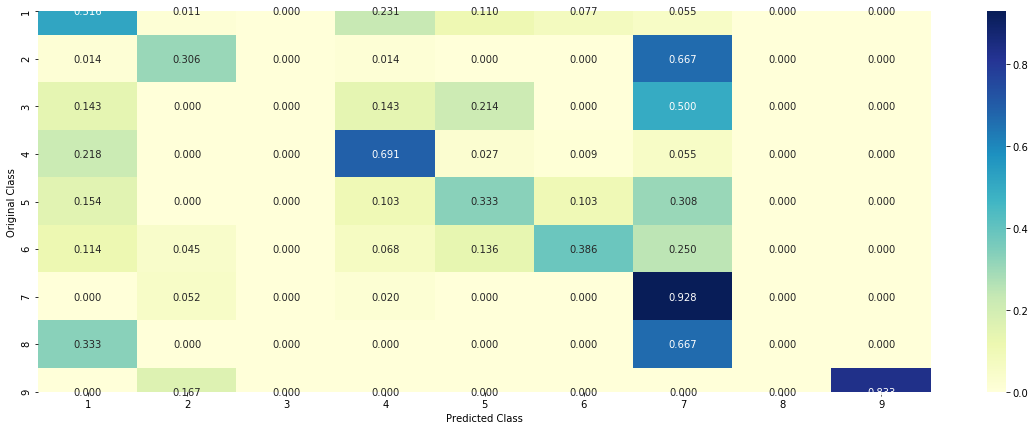

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(4,4))

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer,500)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

Shape after max features =  (2124, 5579667)
Shape after max score =  (2124, 500)
Total number of unique words in train data : 5579667
for alpha = 1e-06
Log Loss : 1.3513999610128906
for alpha = 1e-05
Log Loss : 1.1442789239326583
for alpha = 0.0001
Log Loss : 1.081781333074767
for alpha = 0.001
Log Loss : 1.1226839641784379
for alpha = 0.01
Log Loss : 1.2252930449875892
for alpha = 0.1
Log Loss : 1.3602141087471644
for alpha = 1
Log Loss : 1.4108720329334432
for alpha = 10
Log Loss : 1.4183483774452474
for alpha = 100
Log Loss : 1.4192667644387655


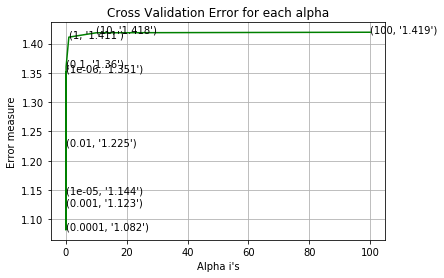

For values of best alpha =  0.0001 The train log loss is: 0.5352116677595705
For values of best alpha =  0.0001 The cross validation log loss is: 1.081781333074767
For values of best alpha =  0.0001 The test log loss is: 1.0828301638024282
Log loss : 1.081781333074767
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


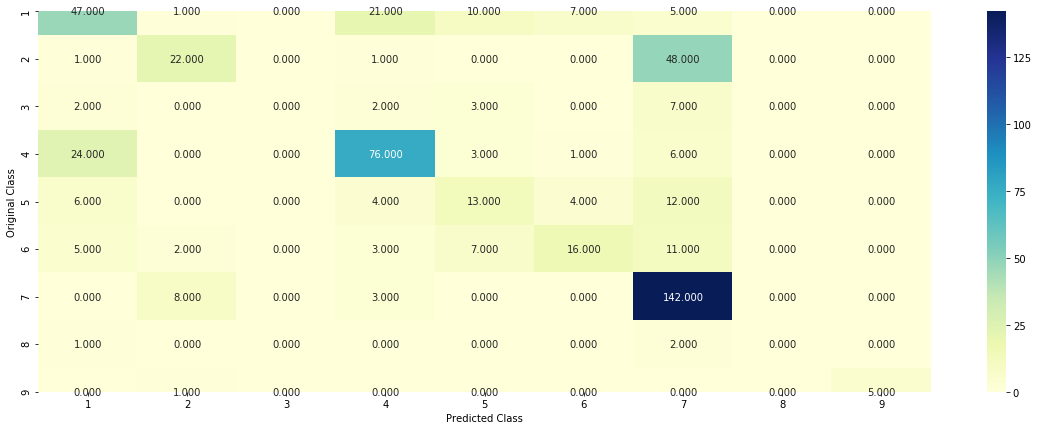

-------------------- Precision matrix (Columm Sum=1) --------------------


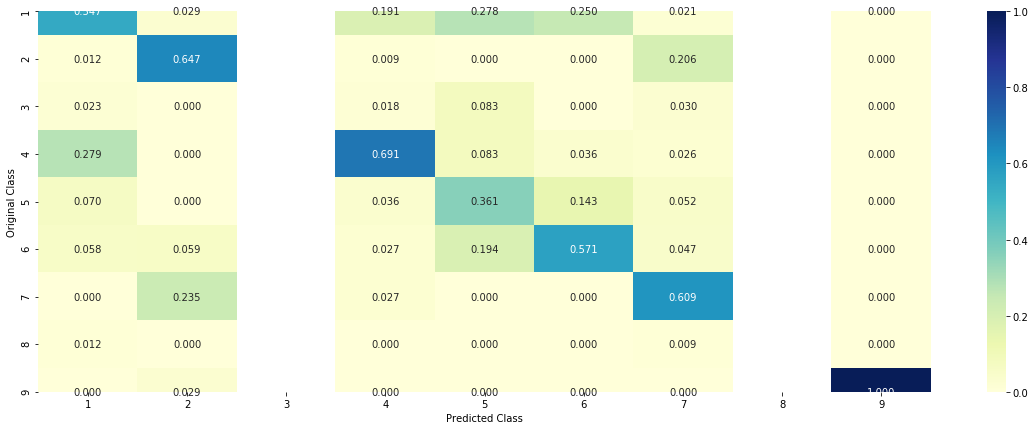

-------------------- Recall matrix (Row sum=1) --------------------


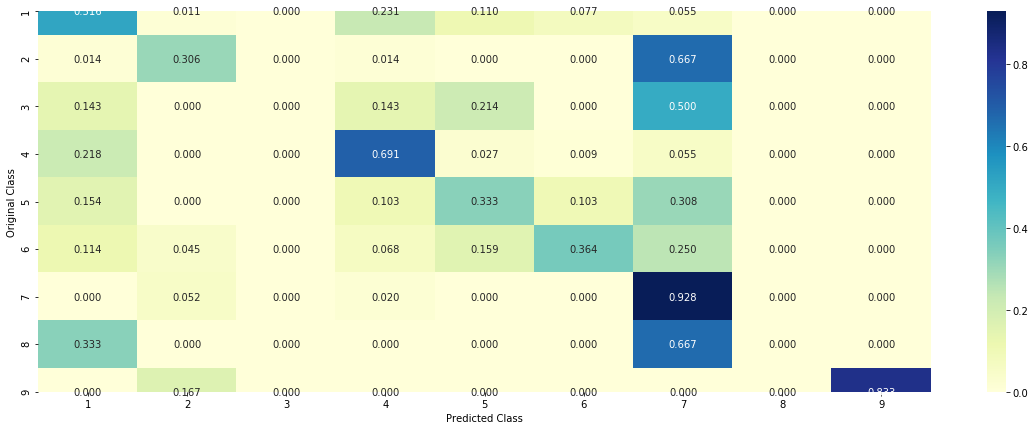

In [ ]:
gene_vectorizer = TfidfVectorizer()
variation_vectorizer =TfidfVectorizer()
text_vectorizer = TfidfVectorizer(ngram_range=(5,5))

train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding = vectorize_selectBestK(gene_vectorizer, variation_vectorizer, text_vectorizer,500)
apply_logistic_regression(train_x_onehotCoding, test_x_onehotCoding, cv_x_onehotCoding)

<h2> Conclusions </h2>

In [ ]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Log Loss", "AUC"]

x.add_row(["Random Model","NA",0.88, "NA"])
x.add_row(["Logistic Regression","TFIDF",0.45, 0.85])
x.add_row(["XGBoost","TFIDF W2V",0.368, 0.90])


print("Performance of Models")
print(x)
print("\n\nBest result is with XGBoost Model with TFIDF W2V vectorizer having Log-Loss = 0.368 and AUC = 0.90 ")

Performance of Models
+---------------------+------------+----------+------+
|        Model        | Vectorizer | Log Loss | AUC  |
+---------------------+------------+----------+------+
|     Random Model    |     NA     |   0.88   |  NA  |
| Logistic Regression |   TFIDF    |   0.45   | 0.85 |
|       XGBoost       | TFIDF W2V  |  0.368   | 0.9  |
+---------------------+------------+----------+------+


Best result is with XGBoost Model with TFIDF W2V vectorizer having Log-Loss = 0.368 and AUC = 0.90 
